In [139]:
import numpy as np
import pandas as pd
import re
import os
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score, precision_score, recall_score, precision_recall_curve

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
from typing import Tuple, Any
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

def basic_summary(data: pd.DataFrame) -> pd.DataFrame:
    """
    basic_summary
    --------------------------------

    Returns basic summary stats for all variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.columns

    stats = pd.DataFrame(index=columns)
    stats['dtype'] =  data[columns].dtypes
    stats['missing_values'] = data[columns].isna().sum()
    stats['missing_values %'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['unique_values'] = data[columns].nunique()

    return stats


def detailed_descriptive_categorical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_categorical
    --------------------------------

    Returns useful summary stats for categorical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """
    columns = data.select_dtypes(exclude=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    stats = pd.DataFrame(index=columns)
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)

    stats['unique_values'] = data[columns].nunique()
    stats['most_frequent'] = data[columns].mode().iloc[0]
    stats['frequency'] = data[columns].apply(
        lambda x: x.value_counts().iloc[0])
    stats['top_5_frequent'] = data[columns].apply(
        lambda x: x.value_counts().head(5).to_dict())
    return stats


def detailed_descriptive_numerical(data: pd.DataFrame) -> pd.DataFrame:
    """
    detailed_descriptive_numerical
    --------------------------------

    Returns useful summary stats for numerical variables 

    Data    : Pandas dataframe
    
    Returns :
        Pandas dataframe with summary
    """

    columns = data.select_dtypes(include=[
                                 'int8', 'int16', 'int32', 'int64', 'Int64', 'float16', 'float32', 'float64']).columns
    # columns = sorted(columns)
    stats = data[columns].describe().round(2).T
    stats['missing_values'] = round (data[columns].isna().sum() / len (data) * 100, 2)
    stats['skew'] = data[columns].skew()
    stats['kurtosis'] = data[columns].kurtosis()
    stats['mode'] = data[columns].mode().iloc[0]
    return stats

def detailed_summary(data: pd.DataFrame, display_top_n=3) -> pd.DataFrame:
    """
    Provides detailed summary for both categorical and numerical variables.

    Data    : Pandas dataframe
    display_top_n : Number of top frequent values to display for categorical variables.
    
    Returns :
        Pandas dataframe with descriptive summary for both categorical and numerical columns.
    """
    # Separate numerical and categorical columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    # Summary for numerical columns
    numerical_summary = data[numerical_columns].describe().T
    numerical_summary['missing_values %'] = round(data[numerical_columns].isna().sum() / len(data) * 100, 2)
    numerical_summary['skew'] = data[numerical_columns].skew()
    numerical_summary['kurtosis'] = data[numerical_columns].kurtosis()

    # Summary for categorical columns
    categorical_summary = pd.DataFrame(index=categorical_columns)
    categorical_summary['missing_values %'] = round(data[categorical_columns].isna().sum() / len(data) * 100, 2)
    categorical_summary['unique_values'] = data[categorical_columns].nunique()
    categorical_summary['most_frequent'] = data[categorical_columns].mode().iloc[0]
    categorical_summary['frequency'] = data[categorical_columns].apply(lambda x: x.value_counts().iloc[0])
    categorical_summary['top_n_frequent'] = data[categorical_columns].apply(
        lambda x: dict(x.value_counts().head(display_top_n))
    )

    # Combine both summaries
    combined_summary = pd.concat([numerical_summary, categorical_summary], axis=0)
    
    return combined_summary


def handle_missing_values(data: pd.DataFrame, strategy="mean", impute_categorical=False, knn_neighbors=5) -> Tuple[Any, pd.DataFrame]:
    """
    Handles missing values in the dataframe based on the provided strategy.
    
    strategy : str, default "mean"
        Imputation strategy for numerical columns:
        - "mean": replaces missing values with mean
        - "median": replaces missing values with median
        - "most_frequent": replaces missing values with the most frequent value
        - "knn": uses KNN imputer
        - "iterative": uses Iterative imputer (more advanced)
    
    impute_categorical : bool, default True
        Whether to impute categorical variables with the most frequent value.
    
    knn_neighbors : int, default 5
        Number of neighbors to use for KNN imputation.
    
    Returns:
        imputer --> useful for imputing test sets or review model parameters.
        DataFrame with missing values handled.
    """
    
    data_cleaned = data.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns
    
    if len(numerical_cols) > 0:
        # Handle missing values for numerical columns
        if strategy in ["mean", "median", "most_frequent"]:
            imputer = SimpleImputer(strategy=strategy)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "knn":
            imputer = KNNImputer(n_neighbors=knn_neighbors)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "iterative":
            imputer = IterativeImputer()
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
    
    # Handle missing values for categorical columns (if applicable)
    if len(categorical_cols) > 0 and impute_categorical:
        imputer = SimpleImputer(strategy="most_frequent")
        data_cleaned[categorical_cols] = imputer.fit_transform(data_cleaned[categorical_cols])
    
    return imputer, data_cleaned


def cap_outliers_isolation_forest(data: pd.DataFrame, columns: list, contamination: float = 0.01) -> pd.DataFrame:
    """
    cap_outliers_isolation_forest
    -----------------------------

    Caps columns in data using Isolation Forest

    data    : Pandas dataframe
    columns : list of columns

    Returns :
        Capped dataframe
    
    """

    clf = IsolationForest(contamination=contamination, random_state=42)

    for column in columns:
        data['outlier_if'] = clf.fit_predict(data[[column]])

        non_outliers = data[data['outlier_if'] == 1][column]
        lower_bound = non_outliers.min()
        upper_bound = non_outliers.max()

        data[column] = np.where(data[column] < lower_bound,
                              lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound,
                              upper_bound, data[column])

        data = data.drop(columns=['outlier_if'])
        print(f'Capped outliers in {column}')

    return data

# Telecom Churn Prediction

# The Plan

#### 1. Data Understanding and Preprocessing
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.

#### 2. Exploratory Data Analysis (EDA)
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

#### 3. Feature Engineering
   - Create new features or transform existing ones.
   - Handle multicollinearity (if applicable).
   - Perform PCA for dimensionality reduction (after scaling/normalization if needed).

#### 4. Feature Scaling/Normalization
   - Apply scaling or normalization depending on the requirements of the models.

#### 5. Principal Component Analysis (PCA)
   - Apply PCA to reduce the dimensionality of the dataset.

#### 6. Handle Class Imbalance (if applicable)
   - If class imbalance exists, apply resampling techniques (over-sampling, under-sampling, or SMOTE).

#### 7. Model Selection
   - Split the data into training and testing sets.
   - Choose multiple models to evaluate:
     - Logistic Regression
     - Decision Trees
     - Random Forest
     - SVM
     - Naive Bayes
     - Boosting methods (XGBoost, LightGBM)
   - Build pipelines for each model.

#### 8. Model Evaluation and Tuning
   - Evaluate model performance on the validation set using metrics such as accuracy, precision, recall, F1-score, ROC-AUC.
   - Use cross-validation to reduce overfitting.
   - Perform hyperparameter tuning (GridSearchCV, RandomSearchCV).

#### 9. Ensemble Modeling (optional)
   - Combine multiple models to improve overall performance using techniques like voting classifiers or stacking.

#### 10. Final Model Evaluation
   - Evaluate the best model on the test set.
   - Calculate final performance metrics.

#### 11. Submission Preparation
   - Prepare predictions on the test dataset.
   - Generate submission file for Kaggle competition.


# 1. **Data Understanding and Preprocessing:**
   - Load and inspect the dataset.
   - Handle missing values if any.
   - Encode categorical variables.
   - Feature scaling and normalization (if necessary).
   - Check for class imbalance and decide on sampling strategies (over-sampling, under-sampling, SMOTE, etc.).


### Load and inspect the dataset.


In [141]:
data = pd.read_csv("https://raw.githubusercontent.com/mohiteamit/upGrad-TelecomChurnCaseStudy/refs/heads/main/data/train.csv")
unseen = pd.read_csv("https://github.com/mohiteamit/upGrad-TelecomChurnCaseStudy/raw/refs/heads/main/data/test.csv")

`Dictionary.csv`

|Acronyms|Description|
|---|---|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls  within same telecom circle|
|STD|STD calls  outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|Operator T to T ie within same operator mobile to mobile|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to its own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage  voice calls|
|AON    |Age on network  number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |G network|
|AV    |Average|
|VOL    |Mobile internet usage volume in MB|
|2G    |G network|
|PCK    |Prepaid service schemes called  PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost  when no specific scheme is not purchased and paid as per usage|

In [142]:
data.head(n=10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.00,0.00,0.00,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.00,0.00,0.00,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0
5,5,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,86.193,83.351,...,0,0,NaN,NaN,NaN,698,0.00,0.00,0.00,0
6,6,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,54.173,95.130,...,0,0,NaN,NaN,NaN,1083,0.00,0.00,0.00,0
7,7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,167.861,167.869,...,0,0,1.0,1.0,1.0,584,82.26,73.56,177.14,0
8,8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,163.550,90.250,...,0,0,NaN,NaN,NaN,2455,0.00,0.00,0.00,1
9,9,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,101.984,259.265,...,0,0,NaN,NaN,NaN,2530,0.00,0.00,0.00,0


### Handle missing values if any.

`Before moving on to handle missing values lets seperate predictors and target variable. This will helps us align train and test and apply missing value strategy to test dataset as well`

In [143]:
X = data.drop(columns=['churn_probability'], axis=1)
y = data['churn_probability']
X.shape, y.shape

((69999, 171), (69999,))

In [144]:
X.columns.equals(unseen.columns) # Checking X and unseen test data as same columns

True

In [145]:
detailed_descriptive_categorical(data=X)

,missing_values,unique_values,most_frequent,frequency,top_5_frequent
last_date_of_month_6,0.00,1,6/30/2014,69999,{'6/30/2014': 69999}
last_date_of_month_7,0.57,1,7/31/2014,69600,{'7/31/2014': 69600}
last_date_of_month_8,1.05,1,8/31/2014,69266,{'8/31/2014': 69266}
date_of_last_rech_6,1.57,30,6/30/2014,11880,"{'6/30/2014': 11880, '6/29/2014': 9049, '6/27/..."
date_of_last_rech_7,1.76,31,7/31/2014,12206,"{'7/31/2014': 12206, '7/30/2014': 9716, '7/25/..."
date_of_last_rech_8,3.52,31,8/31/2014,10324,"{'8/31/2014': 10324, '8/30/2014': 8187, '8/29/..."
date_of_last_rech_data_6,74.90,30,6/30/2014,1317,"{'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2..."
date_of_last_rech_data_7,74.48,31,7/31/2014,1282,"{'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2..."
date_of_last_rech_data_8,73.69,31,8/31/2014,1388,"{'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2..."


**Handling for few date time variables in data**

`The following variables, including the date_of_last_rech_data_*, have missing values. However, these missing values are not random but are indicators of customer behavior, highlighting that the user did not recharge during that month. This information will be leveraged during feature engineering, as the absence of recharge activity is a key signal for predicting churn.`


| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


In [146]:
# Fix data type for datetime columns

X['date_of_last_rech_6'] = pd.to_datetime(X['date_of_last_rech_6'])
X['date_of_last_rech_7'] = pd.to_datetime(X['date_of_last_rech_7'])
X['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'])
X['date_of_last_rech_data_6'] = pd.to_datetime(X['date_of_last_rech_data_6'])
X['date_of_last_rech_data_7'] = pd.to_datetime(X['date_of_last_rech_data_7'])
X['date_of_last_rech_data_8'] = pd.to_datetime(X['date_of_last_rech_data_8'])

# Rest of the columns are in right format

In [147]:
columns_to_keep = [] # Will always hold columns to keep for next step.

In [148]:
columns_to_keep = []
for c in X.columns:
    m =  X[c].isna().sum() / len (X) * 100
    if m < 70:
        columns_to_keep.append(c)

columns_to_keep.append('date_of_last_rech_data_6')
columns_to_keep.append('date_of_last_rech_data_7')
columns_to_keep.append('date_of_last_rech_data_8')


len(columns_to_keep)

144

In [149]:
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] # Ensuring unseen is updated as well

In [150]:
# basic_summary(data=data).sort_values(by='unique_values', ascending=True)

In [151]:
# Let's remove all variables with 1 unique value
basicsummary = basic_summary(data=X)
columns_to_keep = basicsummary[basicsummary['unique_values'] > 1].index
len(columns_to_keep)

131

In [152]:
X = X[columns_to_keep]
unseen = unseen[[v for v in columns_to_keep if not v == 'churn_probability']] # Ensuring unseen is updated as well

In [153]:
basic_summary(data=X).sort_values(by='missing_values %', ascending=False)
# basic_summary(data=X).sort_index()

,dtype,missing_values,missing_values %,unique_values
date_of_last_rech_data_6,datetime64[ns],52431,74.90,30
date_of_last_rech_data_7,datetime64[ns],52134,74.48,31
date_of_last_rech_data_8,datetime64[ns],51582,73.69,31
og_others_8,float64,3703,5.29,179
loc_ic_t2t_mou_8,float64,3703,5.29,11446
...,...,...,...,...
sachet_3g_8,int64,0,0.00,28
jul_vbc_3g,float64,0,0.00,10257
aug_vbc_3g,float64,0,0.00,10609
aon,int64,0,0.00,3455


In [154]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns 

In [155]:
detailed_descriptive_categorical(data=X)

,missing_values,unique_values,most_frequent,frequency,top_5_frequent
date_of_last_rech_6,1.57,30,2014-06-30,11880,"{2014-06-30 00:00:00: 11880, 2014-06-29 00:00:..."
date_of_last_rech_7,1.76,31,2014-07-31,12206,"{2014-07-31 00:00:00: 12206, 2014-07-30 00:00:..."
date_of_last_rech_8,3.52,31,2014-08-31,10324,"{2014-08-31 00:00:00: 10324, 2014-08-30 00:00:..."
date_of_last_rech_data_6,74.90,30,2014-06-30,1317,"{2014-06-30 00:00:00: 1317, 2014-06-29 00:00:0..."
date_of_last_rech_data_7,74.48,31,2014-07-31,1282,"{2014-07-31 00:00:00: 1282, 2014-07-29 00:00:0..."
date_of_last_rech_data_8,73.69,31,2014-08-31,1388,"{2014-08-31 00:00:00: 1388, 2014-08-30 00:00:0..."


`Reminder` we are not going to impute data for following variables

| Column                  | Missing Values (%) | Unique Values | Most Frequent Value | Frequency | Top 5 Frequent                                          |
|-------------------------|--------------------|---------------|---------------------|-----------|---------------------------------------------------------|
| date_of_last_rech_6      | 1.57               | 30            | 6/30/2014           | 11880     | {'6/30/2014': 11880, '6/29/2014': 9049, '6/27/2014': ...} |
| date_of_last_rech_7      | 1.76               | 31            | 7/31/2014           | 12206     | {'7/31/2014': 12206, '7/30/2014': 9716, '7/25/2014': ...} |
| date_of_last_rech_8      | 3.52               | 31            | 8/31/2014           | 10324     | {'8/31/2014': 10324, '8/30/2014': 8187, '8/29/2014': ...} |
| date_of_last_rech_data_6 | 74.90              | 30            | 6/30/2014           | 1317      | {'6/30/2014': 1317, '6/29/2014': 1148, '6/28/2014': ...} |
| date_of_last_rech_data_7 | 74.48              | 31            | 7/31/2014           | 1282      | {'7/31/2014': 1282, '7/29/2014': 1200, '7/30/2014': ...} |
| date_of_last_rech_data_8 | 73.69              | 31            | 8/31/2014           | 1388      | {'8/31/2014': 1388, '8/30/2014': 1306, '8/29/2014': ...} |


--------------


If we we had to impute, following is the code

```python
imputer_catgorical, X[categorical_cols] = handle_missing_values(
    data=X[categorical_cols],
    strategy='most_frequent',
    impute_categorical=True                   
)


In [156]:
# Imputing numeric variables in train set
imputer_numerical, X[numerical_cols] = handle_missing_values(
    data=X[numerical_cols],
    strategy='median'                      
)

In [157]:
# Imputing numerical variables in test set
unseen[numerical_cols]  = imputer_numerical.transform(unseen[numerical_cols])

In [158]:
basic_summary(data=X).sort_values(by='missing_values %', ascending=False).sort_index()

,dtype,missing_values,missing_values %,unique_values
aon,float64,0,0.0,3455
arpu_6,float64,0,0.0,61615
arpu_7,float64,0,0.0,61425
arpu_8,float64,0,0.0,60194
aug_vbc_3g,float64,0,0.0,10609
...,...,...,...,...
vol_2g_mb_7,float64,0,0.0,11443
vol_2g_mb_8,float64,0,0.0,11359
vol_3g_mb_6,float64,0,0.0,9768
vol_3g_mb_7,float64,0,0.0,10296


Summary after handling missing values.

| column | dtype | missing_values | missing_values % | unique_values |
| --- | --- | --- | --- | --- |
| aon | float64 | 0 | 0.00 | 3455 |
| arpu_6 | float64 | 0 | 0.00 | 61615 |
| arpu_7 | float64 | 0 | 0.00 | 61425 |
| arpu_8 | float64 | 0 | 0.00 | 60194 |
| aug_vbc_3g | float64 | 0 | 0.00 | 10609 |
| date_of_last_rech_6 | object | 1101 | 1.57 | 30 |
| date_of_last_rech_7 | object | 1234 | 1.76 | 31 |
| date_of_last_rech_8 | object | 2461 | 3.52 | 31 |
| date_of_last_rech_data_6 | object | 52431 | 74.90 | 30 |
| date_of_last_rech_data_7 | object | 52134 | 74.48 | 31 |
| date_of_last_rech_data_8 | object | 51582 | 73.69 | 31 |
| ic_others_6 | float64 | 0 | 0.00 | 1523 |
| ic_others_7 | float64 | 0 | 0.00 | 1658 |
| ic_others_8 | float64 | 0 | 0.00 | 1565 |
| id | float64 | 0 | 0.00 | 69999 |
| isd_ic_mou_6 | float64 | 0 | 0.00 | 4421 |
| isd_ic_mou_7 | float64 | 0 | 0.00 | 4640 |
| isd_ic_mou_8 | float64 | 0 | 0.00 | 4694 |
| isd_og_mou_6 | float64 | 0 | 0.00 | 1103 |
| isd_og_mou_7 | float64 | 0 | 0.00 | 1084 |
| isd_og_mou_8 | float64 | 0 | 0.00 | 1008 |
| jul_vbc_3g | float64 | 0 | 0.00 | 10257 |
| jun_vbc_3g | float64 | 0 | 0.00 | 9617 |
| last_day_rch_amt_6 | float64 | 0 | 0.00 | 179 |
| last_day_rch_amt_7 | float64 | 0 | 0.00 | 166 |
| last_day_rch_amt_8 | float64 | 0 | 0.00 | 191 |
| loc_ic_mou_6 | float64 | 0 | 0.00 | 24442 |
| loc_ic_mou_7 | float64 | 0 | 0.00 | 24258 |
| loc_ic_mou_8 | float64 | 0 | 0.00 | 24182 |
| loc_ic_t2f_mou_6 | float64 | 0 | 0.00 | 6200 |
| loc_ic_t2f_mou_7 | float64 | 0 | 0.00 | 6287 |
| loc_ic_t2f_mou_8 | float64 | 0 | 0.00 | 6092 |
| loc_ic_t2m_mou_6 | float64 | 0 | 0.00 | 19034 |
| loc_ic_t2m_mou_7 | float64 | 0 | 0.00 | 18945 |
| loc_ic_t2m_mou_8 | float64 | 0 | 0.00 | 19022 |
| loc_ic_t2t_mou_6 | float64 | 0 | 0.00 | 11637 |
| loc_ic_t2t_mou_7 | float64 | 0 | 0.00 | 11595 |
| loc_ic_t2t_mou_8 | float64 | 0 | 0.00 | 11446 |
| loc_og_mou_6 | float64 | 0 | 0.00 | 22309 |
| loc_og_mou_7 | float64 | 0 | 0.00 | 22012 |
| loc_og_mou_8 | float64 | 0 | 0.00 | 21951 |
| loc_og_t2c_mou_6 | float64 | 0 | 0.00 | 1945 |
| loc_og_t2c_mou_7 | float64 | 0 | 0.00 | 2103 |
| loc_og_t2c_mou_8 | float64 | 0 | 0.00 | 2204 |
| loc_og_t2f_mou_6 | float64 | 0 | 0.00 | 3376 |
| loc_og_t2f_mou_7 | float64 | 0 | 0.00 | 3365 |
| loc_og_t2f_mou_8 | float64 | 0 | 0.00 | 3311 |
| loc_og_t2m_mou_6 | float64 | 0 | 0.00 | 17848 |
| loc_og_t2m_mou_7 | float64 | 0 | 0.00 | 17642 |
| loc_og_t2m_mou_8 | float64 | 0 | 0.00 | 17617 |
| loc_og_t2t_mou_6 | float64 | 0 | 0.00 | 11491 |
| loc_og_t2t_mou_7 | float64 | 0 | 0.00 | 11359 |
| loc_og_t2t_mou_8 | float64 | 0 | 0.00 | 11296 |
| max_rech_amt_6 | float64 | 0 | 0.00 | 190 |
| max_rech_amt_7 | float64 | 0 | 0.00 | 178 |
| max_rech_amt_8 | float64 | 0 | 0.00 | 202 |
| monthly_2g_6 | float64 | 0 | 0.00 | 5 |
| monthly_2g_7 | float64 | 0 | 0.00 | 6 |
| monthly_2g_8 | float64 | 0 | 0.00 | 6 |
| monthly_3g_6 | float64 | 0 | 0.00 | 10 |
| monthly_3g_7 | float64 | 0 | 0.00 | 13 |
| monthly_3g_8 | float64 | 0 | 0.00 | 12 |
| offnet_mou_6 | float64 | 0 | 0.00 | 26254 |
| offnet_mou_7 | float64 | 0 | 0.00 | 26140 |
| offnet_mou_8 | float64 | 0 | 0.00 | 25996 |
| og_others_6 | float64 | 0 | 0.00 | 914 |
| og_others_7 | float64 | 0 | 0.00 | 148 |
| og_others_8 | float64 | 0 | 0.00 | 179 |
| onnet_mou_6 | float64 | 0 | 0.00 | 20057 |
| onnet_mou_7 | float64 | 0 | 0.00 | 20076 |
| onnet_mou_8 | float64 | 0 | 0.00 | 19726 |
| roam_ic_mou_6 | float64 | 0 | 0.00 | 5306 |
| roam_ic_mou_7 | float64 | 0 | 0.00 | 4240 |
| roam_ic_mou_8 | float64 | 0 | 0.00 | 4252 |
| roam_og_mou_6 | float64 | 0 | 0.00 | 6568 |
| roam_og_mou_7 | float64 | 0 | 0.00 | 5305 |
| roam_og_mou_8 | float64 | 0 | 0.00 | 5215 |
| sachet_2g_6 | float64 | 0 | 0.00 | 30 |
| sachet_2g_7 | float64 | 0 | 0.00 | 33 |
| sachet_2g_8 | float64 | 0 | 0.00 | 32 |
| sachet_3g_6 | float64 | 0 | 0.00 | 23 |
| sachet_3g_7 | float64 | 0 | 0.00 | 26 |
| sachet_3g_8 | float64 | 0 | 0.00 | 28 |
| spl_ic_mou_6 | float64 | 0 | 0.00 | 78 |
| spl_ic_mou_7 | float64 | 0 | 0.00 | 103 |
| spl_ic_mou_8 | float64 | 0 | 0.00 | 95 |
| spl_og_mou_6 | float64 | 0 | 0.00 | 3503 |
| spl_og_mou_7 | float64 | 0 | 0.00 | 3827 |
| spl_og_mou_8 | float64 | 0 | 0.00 | 3848 |
| std_ic_mou_6 | float64 | 0 | 0.00 | 9876 |
| std_ic_mou_7 | float64 | 0 | 0.00 | 10112 |
| std_ic_mou_8 | float64 | 0 | 0.00 | 9939 |
| std_ic_t2f_mou_6 | float64 | 0 | 0.00 | 2624 |
| std_ic_t2f_mou_7 | float64 | 0 | 0.00 | 2695 |
| std_ic_t2f_mou_8 | float64 | 0 | 0.00 | 2583 |
| std_ic_t2m_mou_6 | float64 | 0 | 0.00 | 7931 |
| std_ic_t2m_mou_7 | float64 | 0 | 0.00 | 8033 |
| std_ic_t2m_mou_8 | float64 | 0 | 0.00 | 7906 |
| std_ic_t2t_mou_6 | float64 | 0 | 0.00 | 5323 |
| std_ic_t2t_mou_7 | float64 | 0 | 0.00 | 5479 |
| std_ic_t2t_mou_8 | float64 | 0 | 0.00 | 5367 |
| std_og_mou_6 | float64 | 0 | 0.00 | 21837 |
| std_og_mou_7 | float64 | 0 | 0.00 | 22088 |
| std_og_mou_8 | float64 | 0 | 0.00 | 21746 |
| std_og_t2f_mou_6 | float64 | 0 | 0.00 | 2074 |
| std_og_t2f_mou_7 | float64 | 0 | 0.00 | 1991 |
| std_og_t2f_mou_8 | float64 | 0 | 0.00 | 1945 |
| std_og_t2m_mou_6 | float64 | 0 | 0.00 | 16059 |
| std_og_t2m_mou_7 | float64 | 0 | 0.00 | 16234 |
| std_og_t2m_mou_8 | float64 | 0 | 0.00 | 15968 |
| std_og_t2t_mou_6 | float64 | 0 | 0.00 | 14554 |
| std_og_t2t_mou_7 | float64 | 0 | 0.00 | 14745 |
| std_og_t2t_mou_8 | float64 | 0 | 0.00 | 14483 |
| total_ic_mou_6 | float64 | 0 | 0.00 | 27432 |
| total_ic_mou_7 | float64 | 0 | 0.00 | 27418 |
| total_ic_mou_8 | float64 | 0 | 0.00 | 27318 |
| total_og_mou_6 | float64 | 0 | 0.00 | 33135 |
| total_og_mou_7 | float64 | 0 | 0.00 | 33195 |
| total_og_mou_8 | float64 | 0 | 0.00 | 32897 |
| total_rech_amt_6 | float64 | 0 | 0.00 | 2108 |
| total_rech_amt_7 | float64 | 0 | 0.00 | 2147 |
| total_rech_amt_8 | float64 | 0 | 0.00 | 2149 |
| total_rech_num_6 | float64 | 0 | 0.00 | 94 |
| total_rech_num_7 | float64 | 0 | 0.00 | 96 |
| total_rech_num_8 | float64 | 0 | 0.00 | 92 |
| vol_2g_mb_6 | float64 | 0 | 0.00 | 11494 |
| vol_2g_mb_7 | float64 | 0 | 0.00 | 11443 |
| vol_2g_mb_8 | float64 | 0 | 0.00 | 11359 |
| vol_3g_mb_6 | float64 | 0 | 0.00 | 9768 |
| vol_3g_mb_7 | float64 | 0 | 0.00 | 10296 |
| vol_3g_mb_8 | float64 | 0 | 0.00 | 10663 |


### Encode categorical variables

No categorical variables to encode

In [159]:
X.shape, y.shape, unseen.shape

((69999, 131), (69999,), (30000, 131))

In [160]:
# Build data back to what it should have been
data = pd.concat([X, y], join='inner', axis=1)

In [161]:
data.head(n=5).T

,0,1,2,3,4
id,0.0,1.0,2.0,3.0,4.0
arpu_6,31.277,0.0,60.806,156.362,240.708
arpu_7,87.009,122.787,103.176,205.26,128.191
arpu_8,7.527,42.953,0.0,111.095,101.565
onnet_mou_6,48.58,0.0,0.53,7.26,21.28
...,...,...,...,...,...
jun_vbc_3g,0.0,0.0,0.0,0.0,0.0
date_of_last_rech_data_6,NaT,NaT,NaT,NaT,2014-06-25 00:00:00
date_of_last_rech_data_7,NaT,2014-07-08 00:00:00,NaT,NaT,2014-07-23 00:00:00
date_of_last_rech_data_8,NaT,NaT,NaT,NaT,2014-08-20 00:00:00


# 2. Exploratory Data Analysis (EDA)
   - Visualize the data distribution.
   - Understand feature relationships.
   - Identify trends and correlations.
   - Perform hypothesis testing if needed.

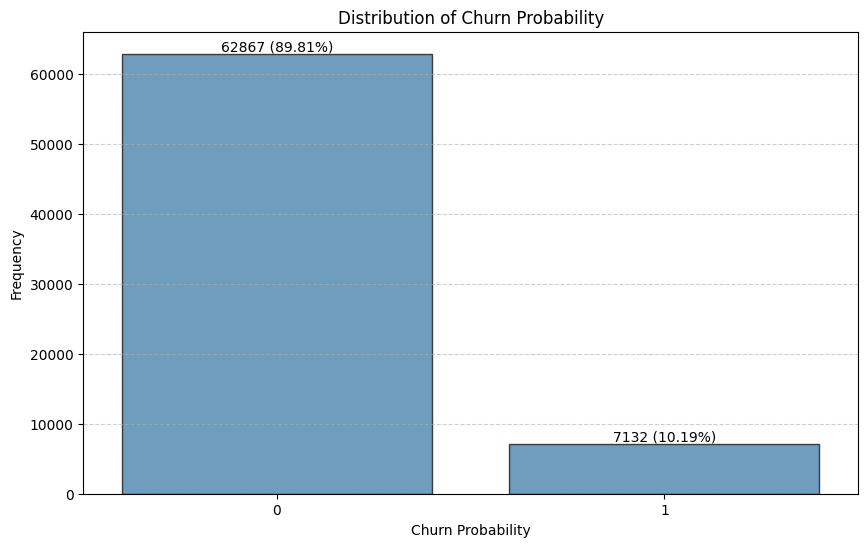

In [162]:
plt.figure(figsize=(10, 6))
churn_counts = data['churn_probability'].value_counts().sort_index()
sns.barplot(x=churn_counts.index, y=churn_counts.values, edgecolor='black', alpha=0.7)

# Add exact count and percentage to the chart for 0 and 1
count_0, count_1 = churn_counts[0], churn_counts[1]
percentage_0 = (count_0 / len(data)) * 100
percentage_1 = (count_1 / len(data)) * 100

plt.text(0, count_0, f'{int(count_0)} ({percentage_0:.2f}%)', ha='center', va='bottom')
plt.text(1, count_1, f'{int(count_1)} ({percentage_1:.2f}%)', ha='center', va='bottom')

plt.title('Distribution of Churn Probability')
plt.xlabel('Churn Probability')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

`We are not going to review each variable one by one as number of variables is large`


### Correlation 

We will look at correalation of each variable pair and see if some what story it tells us

In [163]:
# Create a temporary copy of the data without the 'id' column
data_temp = data.drop(columns=['id'])

# Divide the data by churn probability
data_churn_0 = data_temp[data_temp['churn_probability'] == 0]
data_churn_1 = data_temp[data_temp['churn_probability'] == 1]

# Calculate the correlation matrix for each group and the overall correlation matrix
correlation_matrix_total = data_temp.corr().round(4)
correlation_matrix_0 = data_churn_0.corr().round(4)
correlation_matrix_1 = data_churn_1.corr().round(4)

# Get the upper triangle of the correlation matrix for each group and the total
upper_triangle_total = correlation_matrix_total.where(
    np.triu(np.ones(correlation_matrix_total.shape), k=1).astype(bool)
)
upper_triangle_0 = correlation_matrix_0.where(
    np.triu(np.ones(correlation_matrix_0.shape), k=1).astype(bool)
)
upper_triangle_1 = correlation_matrix_1.where(
    np.triu(np.ones(correlation_matrix_1.shape), k=1).astype(bool)
)

# Unstack the matrices and drop NaN values
correlation_pairs_total = upper_triangle_total.unstack().dropna()
correlation_pairs_0 = upper_triangle_0.unstack().dropna()
correlation_pairs_1 = upper_triangle_1.unstack().dropna()

# Convert the correlation pairs to dataframes
correlation_pairs_df_total = correlation_pairs_total.reset_index()
correlation_pairs_df_total.columns = ['Variable 1', 'Variable 2', 'Correlation (Total)']

correlation_pairs_df_0 = correlation_pairs_0.reset_index()
correlation_pairs_df_0.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=0)']

correlation_pairs_df_1 = correlation_pairs_1.reset_index()
correlation_pairs_df_1.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=1)']

# Merge the correlation dataframes
correlation_pairs_df = correlation_pairs_df_total.merge(correlation_pairs_df_0, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df = correlation_pairs_df.merge(correlation_pairs_df_1, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df['Correlation (Total) (ABS)'] = correlation_pairs_df['Correlation (Total)'].abs()
correlation_pairs_df['Correlation (Churn=0) (ABS)'] = correlation_pairs_df['Correlation (Churn=0)'].abs()
correlation_pairs_df['Correlation (Churn=1) (ABS)'] = correlation_pairs_df['Correlation (Churn=1)'].abs()

# Save the merged correlation pairs to a CSV file
correlation_pairs_df.to_csv('correlation_pairs_combined.csv', index=False)

print("Combined correlation pairs saved to 'correlation_pairs_combined.csv'")

Combined correlation pairs saved to 'correlation_pairs_combined.csv'


### Review of correlation scores


1. Revenue v/s recharge
- Correlation of revenue with respective month indicate recharge for the month is directly reflected towards revenue for the month
- Low correlation between revenue and recharge amounged churned users may also indicate users tend to spend less as they churn
- Number of recharge follow similat trend

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_amt_8 | arpu_8 | 0.9583 | 0.9582 | 0.9405 |
| total_rech_amt_7 | arpu_7 | 0.9553 | 0.9560 | 0.9461 |
| total_rech_amt_6 | arpu_6 | 0.9528 | 0.9536 | 0.9477 |
| total_rech_amt_7 | arpu_8 | 0.7788 | 0.8003 | 0.5374 |
| total_rech_amt_8 | arpu_7 | 0.7672 | 0.7913 | 0.4927 |
| total_rech_amt_6 | arpu_7 | 0.7511 | 0.7880 | 0.4823 |
| total_rech_amt_7 | arpu_6 | 0.7260 | 0.7705 | 0.4173 |
| total_rech_amt_6 | arpu_8 | 0.6390 | 0.6936 | 0.2420 |
| total_rech_amt_8 | arpu_6 | 0.6268 | 0.6871 | 0.1989 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_num_8 | total_rech_num_7 | 0.7239 | 0.7418 | 0.5518 |
| total_rech_num_7 | total_rech_num_6 | 0.6703 | 0.7002 | 0.4854 |
| total_rech_num_8 | total_rech_num_6 | 0.5167 | 0.5649 | 0.2084 |


2. Outgoin ISD calls

- Users likey start making less call as the are about to churn as shown in reduced correlation in churn v/s previous month 
- User which do not churn continue to likely make similar amount of calls

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_og_mou_8 | total_og_mou_7 | 0.7693 | 0.7928 | 0.5873 |
| total_og_mou_7 | total_og_mou_6 | 0.7245 | 0.7464 | 0.6102 |
| total_og_mou_8 | total_og_mou_6 | 0.5659 | 0.6157 | 0.2840 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| isd_og_mou_8 | isd_og_mou_7 | 0.9470 | 0.9582 | 0.5492 |
| isd_og_mou_7 | isd_og_mou_6 | 0.9340 | 0.9588 | 0.4444 |
| isd_og_mou_8 | isd_og_mou_6 | 0.9241 | 0.9526 | 0.2640 |

3. Churn v/s age of network
- Very low negative correlation indicating as age increases churn probability reduces but is not guaranteed
- This correlation is likely affected by class imbalance as well and I would other expect bit higher negative correlation

| Variable 1 | Variable 2 | Correlation (Total) |
| --- | --- | --- |
| churn_probability | aon | -0.1352 |


4. Within operator network and outside operator network
- Similar trend of low correlation between months which are further apart, indicating call volume goes down as people churn.

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| onnet_mou_8 | onnet_mou_7 | 0.7875 | 0.8081 | 0.6340 |
| onnet_mou_7 | onnet_mou_6 | 0.7339 | 0.7510 | 0.6528 |
| onnet_mou_8 | onnet_mou_6 | 0.5978 | 0.6421 | 0.3567 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| offnet_mou_8 | offnet_mou_7 | 0.7557 | 0.7796 | 0.5331 |
| offnet_mou_7 | offnet_mou_6 | 0.7405 | 0.7597 | 0.6321 |
| offnet_mou_8 | offnet_mou_6 | 0.5734 | 0.6178 | 0.2713 |



`Based on above we may explore creating features which capture change usages` 

In [164]:
# Assume current date is 1-Sept-2014
current_date = datetime(2014, 9, 1)

# Calculate number of days since last recharge for each column and add new features to 'data'
recharge_columns = [
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'
]

last_recharge = data[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].max(axis=1)
data['days_since_last_rech'] = (current_date - last_recharge).dt.days

last_recharge_data = data[['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']].max(axis=1)
data['days_since_last_rech_data'] = (current_date - last_recharge_data).dt.days

In [168]:
numerical_cols = data.select_dtypes(include=['number']).columns
non_numeric_cols = data.select_dtypes(exclude=['number']).columns

In [169]:
def change_in_usages(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> pd.Series:
    """
    Calculate the rolling slope of usage volume between June, July, and August to capture trends.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the usage data.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.

    Returns:
    pd.Series with slope
    """
    # Create a DataFrame containing the usage columns for June, July, and August
    usage_df = data[[col_june, col_july, col_aug]]
    
    # Calculate the slope using numpy's polyfit function (degree 1 for linear fit)
    slope = usage_df.apply(lambda row: np.polyfit([1, 2, 3], row, 1)[0], axis=1)
    return slope

In [170]:
def plot_usage_volume(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Prepare data for plotting
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    base_name = col_june[:-2]

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(categories, churned_values, label='Churned', marker='o', color='red')
    plt.plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')

    plt.xlabel('Month')
    plt.ylabel('Average Usage Volume')
    plt.title(f'{base_name}\nAverage Usage Volume Comparison: Churned vs Non-Churned Users')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [171]:
def get_monthly_column_groups(data: pd.DataFrame) -> list[tuple[str, str, str]]:
    """
    Find columns with names ending in _6, _7, and _8 and return them as a list of tuples.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the column names.

    Returns:
    list[tuple[str, str, str]]: A list of tuples, where each tuple contains the column names for June (_6), July (_7), and August (_8).
    """
    columns_6 = [col for col in data.columns if col.endswith('_6')]
    columns_7 = [col for col in data.columns if col.endswith('_7')]
    columns_8 = [col for col in data.columns if col.endswith('_8')]

    monthly_columns = []
    for col_6 in columns_6:
        base_name = col_6[:-2]
        col_7 = f'{base_name}_7'
        col_8 = f'{base_name}_8'
        if col_7 in columns_7 and col_8 in columns_8:
            monthly_columns.append((col_6, col_7, col_8))

    return monthly_columns

In [172]:
def plot_slope_comparison(data: pd.DataFrame, slope: pd.Series) -> None:
    """
    Plot line graph showing the rolling slope of usage volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a churn indicator.
    slope (pd.Series): The calculated rolling slope of usage volume.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Get slopes for churned and non-churned users
    slope_churned = slope.loc[churned.index]
    slope_non_churned = slope.loc[non_churned.index]

    # Calculate mean slopes for plotting
    mean_slope_churned = slope_churned.mean()
    mean_slope_non_churned = slope_non_churned.mean()

    # Plotting
    categories = ['Churned', 'Non-Churned']
    slopes = [mean_slope_churned, mean_slope_non_churned]

    plt.figure(figsize=(6, 4))
    plt.bar(categories, slopes, color=['red', 'green'])
    plt.xlabel('User Group')
    plt.ylabel('Average Rolling Slope of Usage Volume')
    plt.title('Rolling Slope Comparison: Churned vs Non-Churned Users')
    plt.tight_layout()
    plt.show()

In [173]:
def plot_combined_metrics(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str, slope: pd.Series) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn, along with the rolling slope comparison.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    slope (pd.Series): The calculated rolling slope of usage volume.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Get slopes for churned and non-churned users
    slope_churned = slope.loc[churned.index]
    slope_non_churned = slope.loc[non_churned.index]

    # Calculate mean slopes for plotting
    mean_slope_churned = slope_churned.mean()
    mean_slope_non_churned = slope_non_churned.mean()

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Usage Analysis for {col_june[:-2]}', fontsize=16)


    # Plot average usage volume comparison
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    axs[0].plot(categories, churned_values, label='Churned', marker='o', color='red')
    axs[0].plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')
    axs[0].set_xlabel('Month')
    axs[0].set_ylabel('Average Usage Volume')
    axs[0].set_title('Average Usage Volume Comparison: Churned vs Non-Churned Users')
    axs[0].legend()

    # Plot rolling slope comparison
    categories = ['Churned', 'Non-Churned']
    slopes = [mean_slope_churned, mean_slope_non_churned]

    axs[1].bar(categories, slopes, color=['red', 'green'])
    axs[1].set_xlabel('User Group')
    axs[1].set_ylabel('Average Rolling Slope of Usage Volume')
    axs[1].set_title('Rolling Slope Comparison: Churned vs Non-Churned Users')

    plt.tight_layout()
    plt.show()

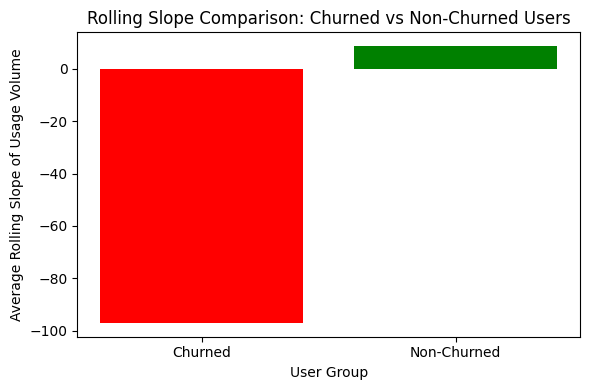

In [174]:
col_june='arpu_6'
col_july='arpu_7'
col_aug='arpu_8' 

slope = change_in_usages(
    data=data,
    col_june=col_june,
    col_july=col_july,
    col_aug=col_aug
)

plot_slope_comparison(
    data=data,
    slope=slope
)

In [175]:
column_groups = get_monthly_column_groups (data=data)
len(column_groups)

42

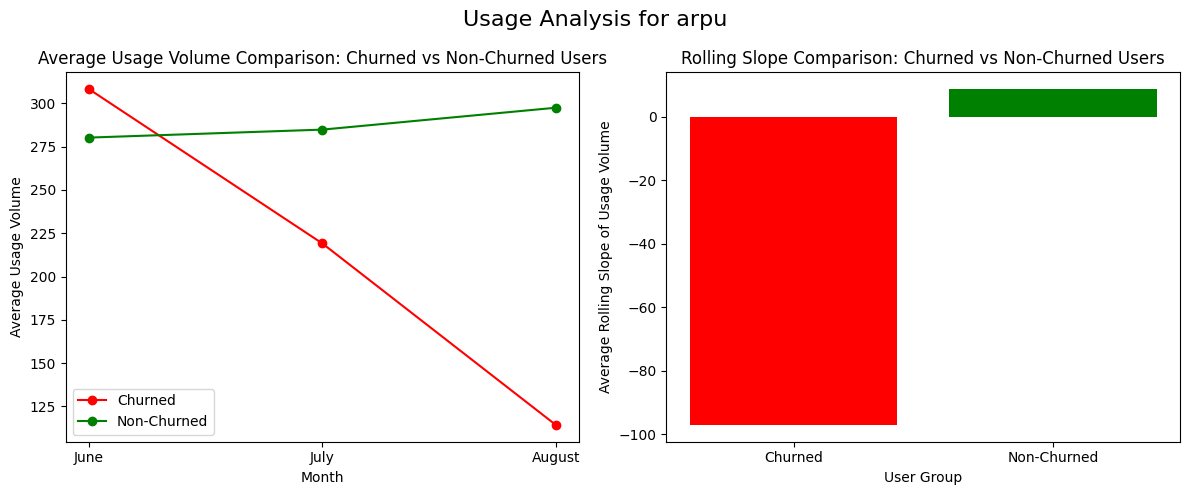

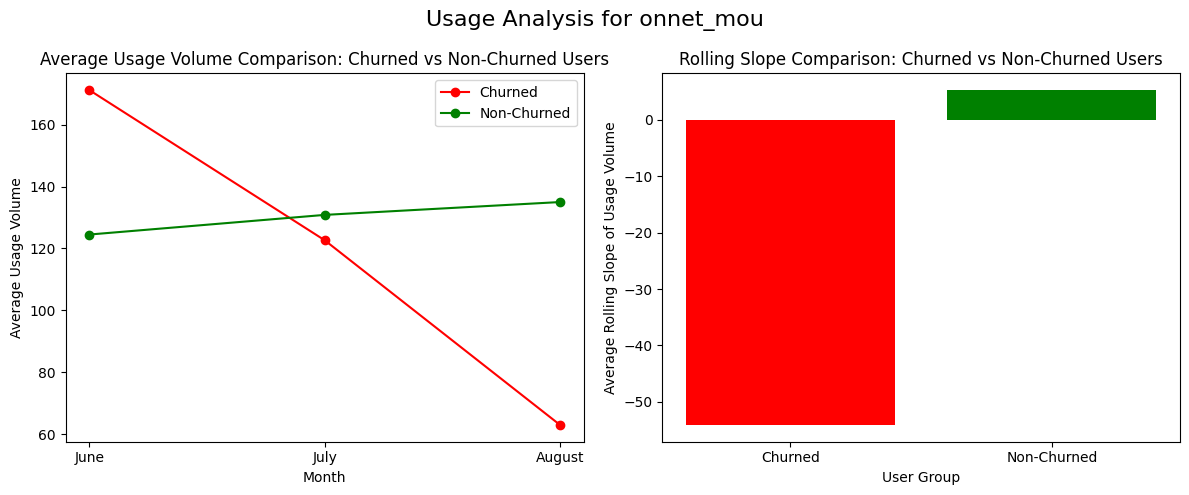

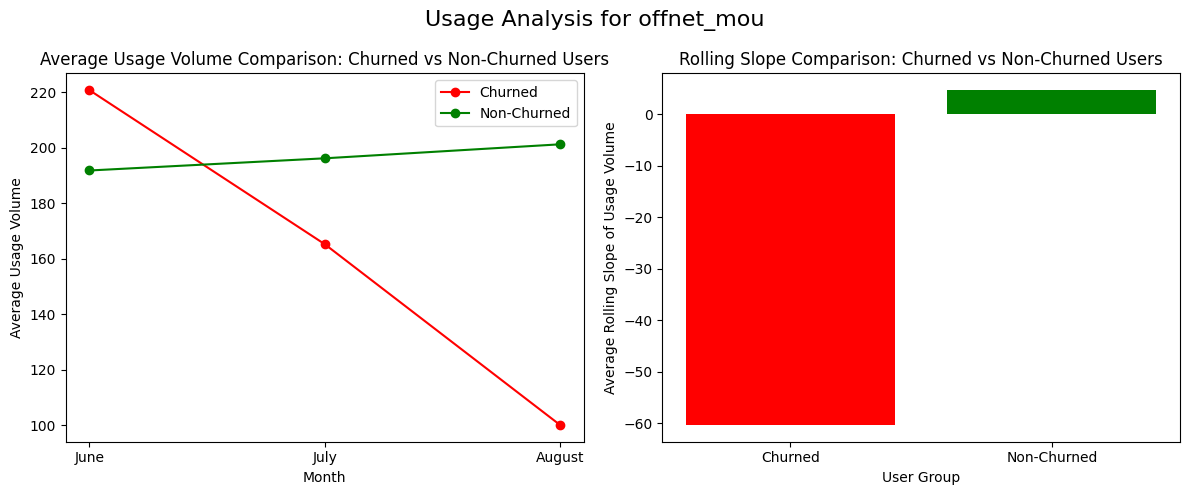

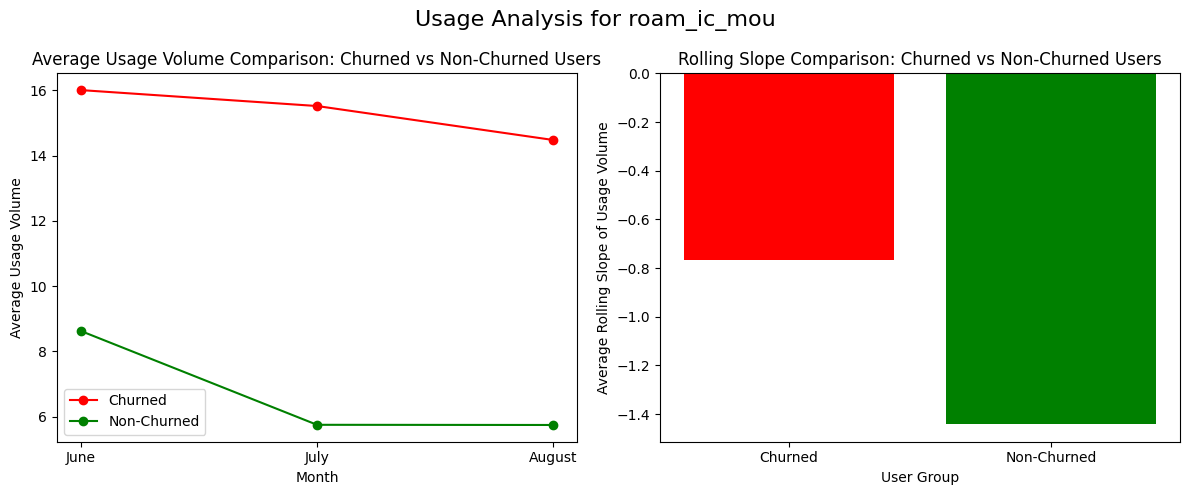

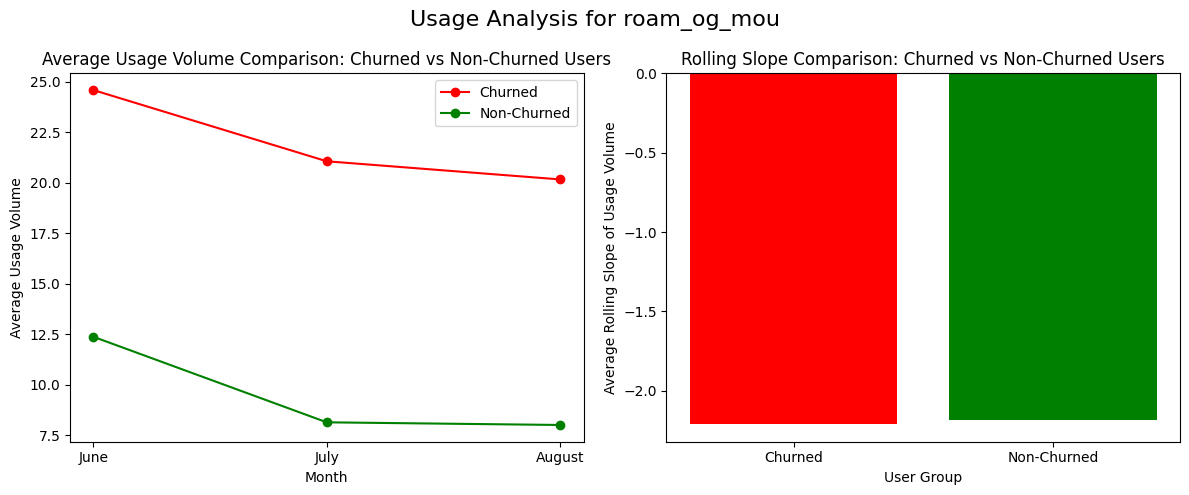

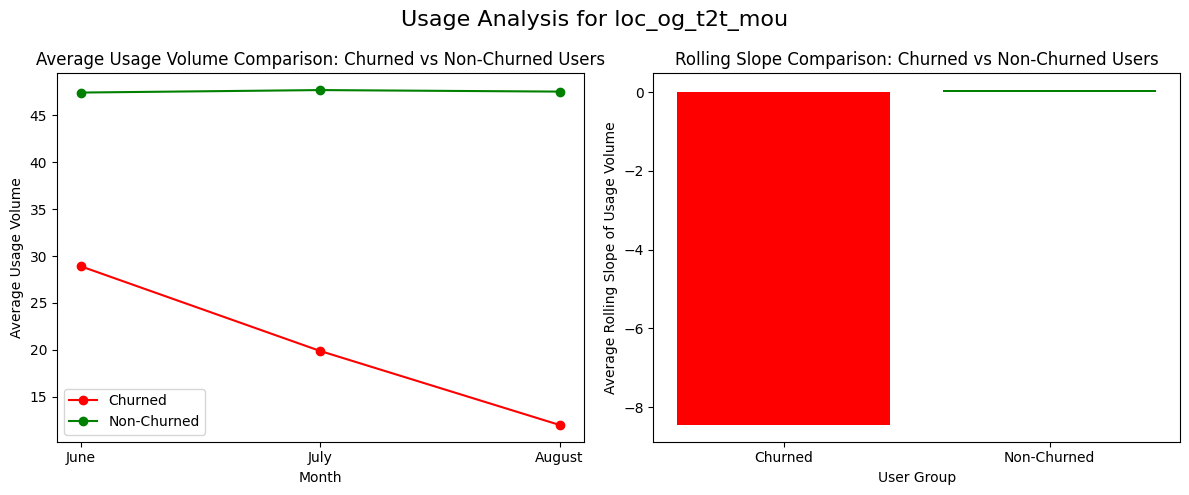

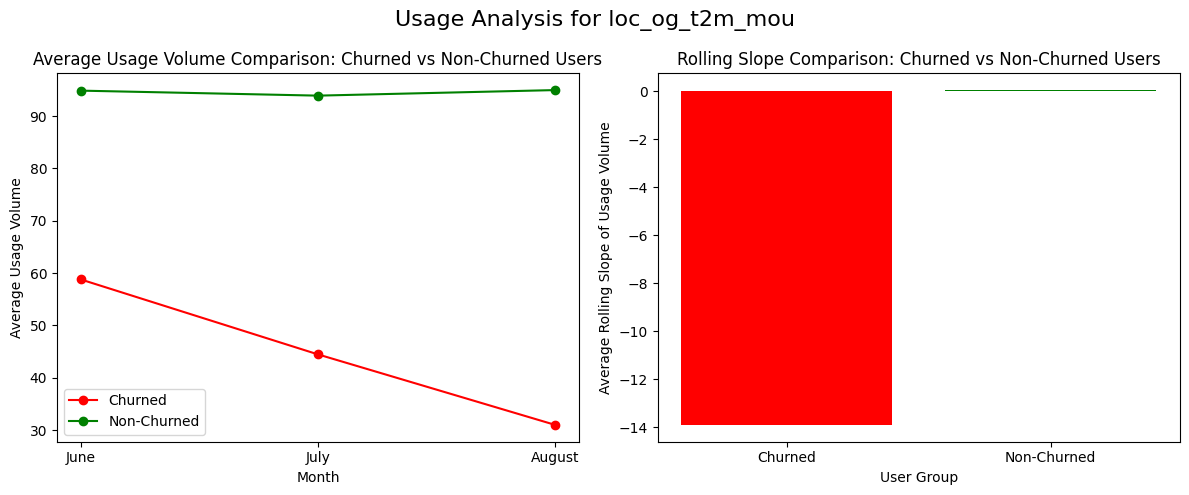

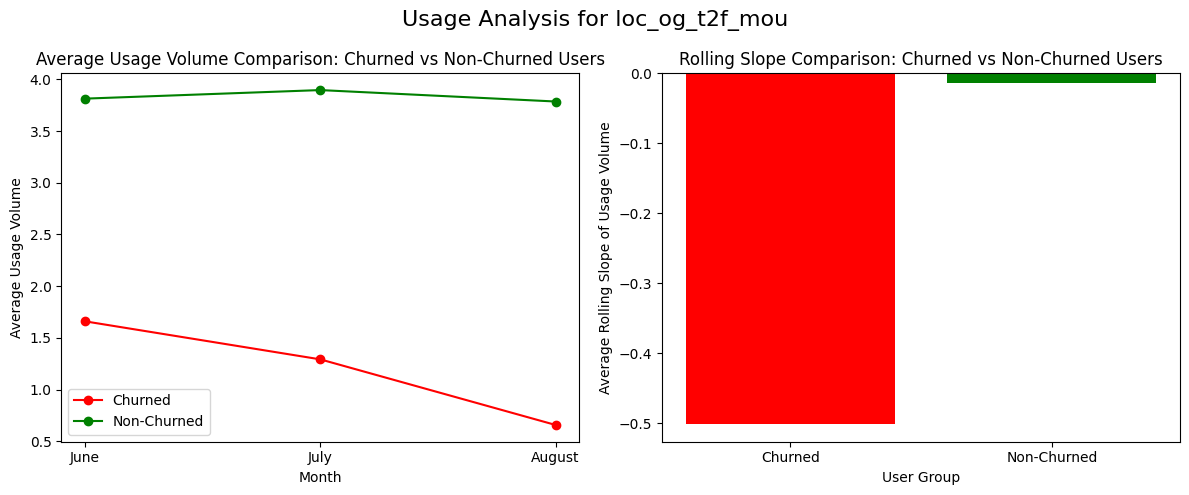

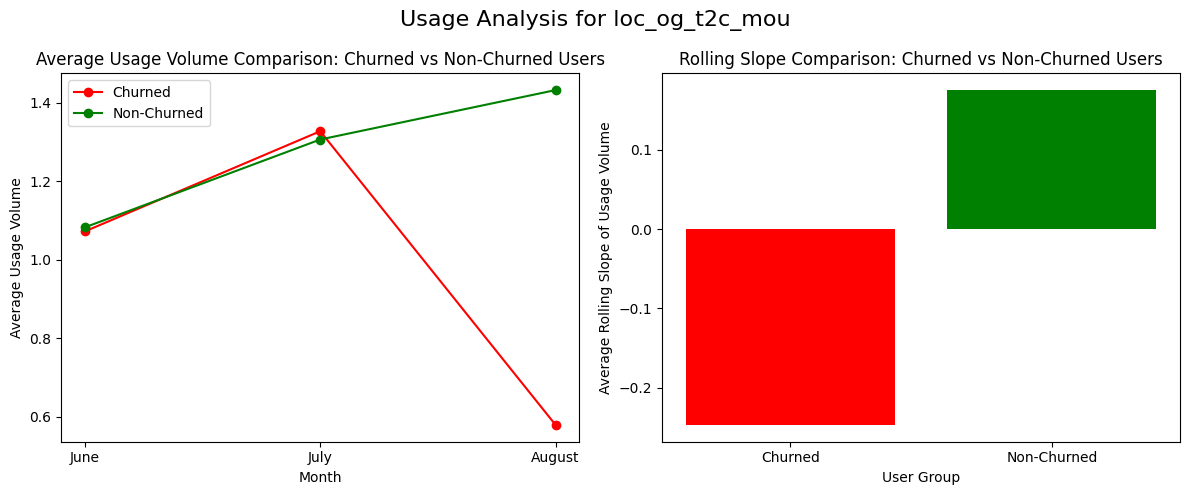

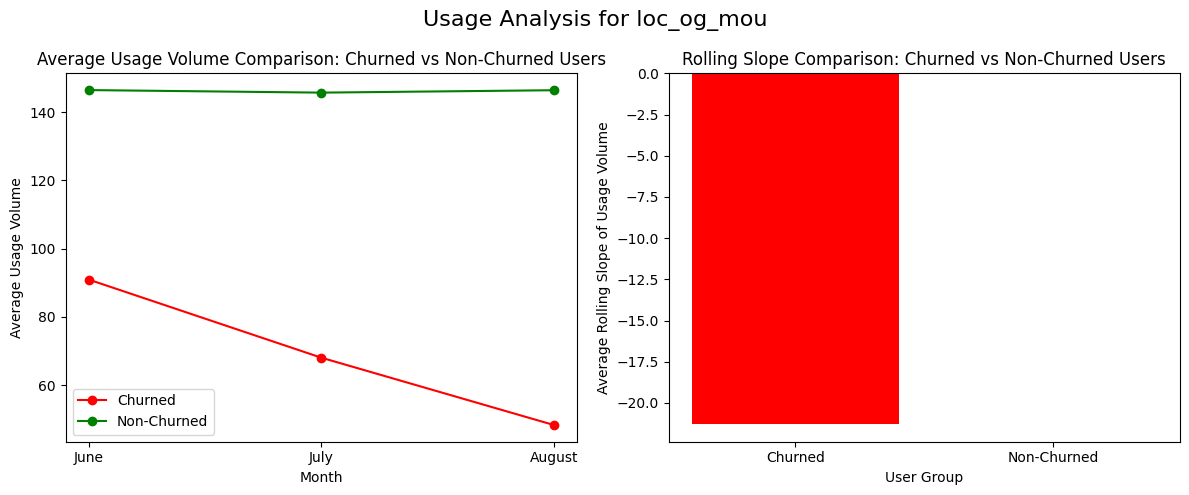

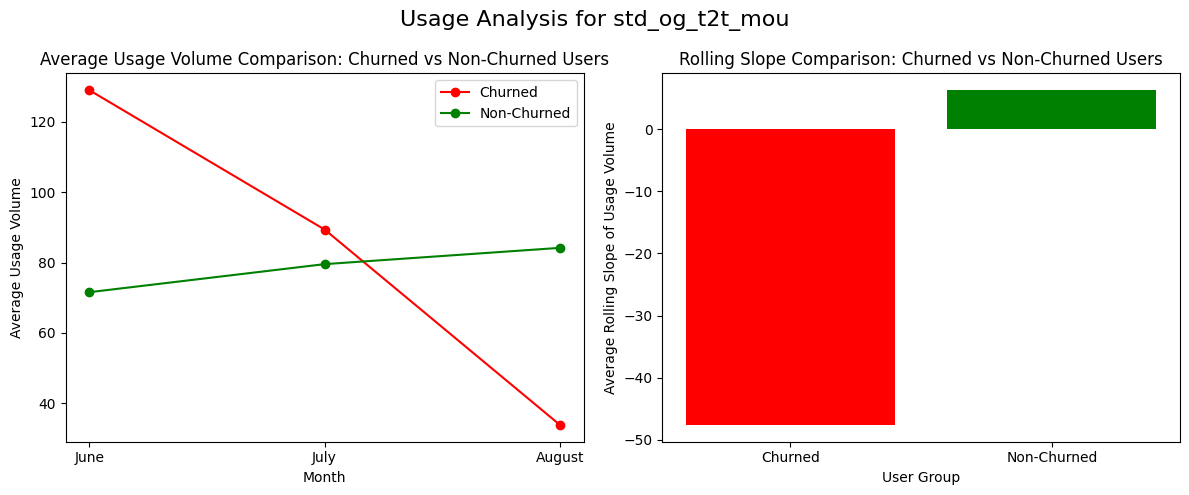

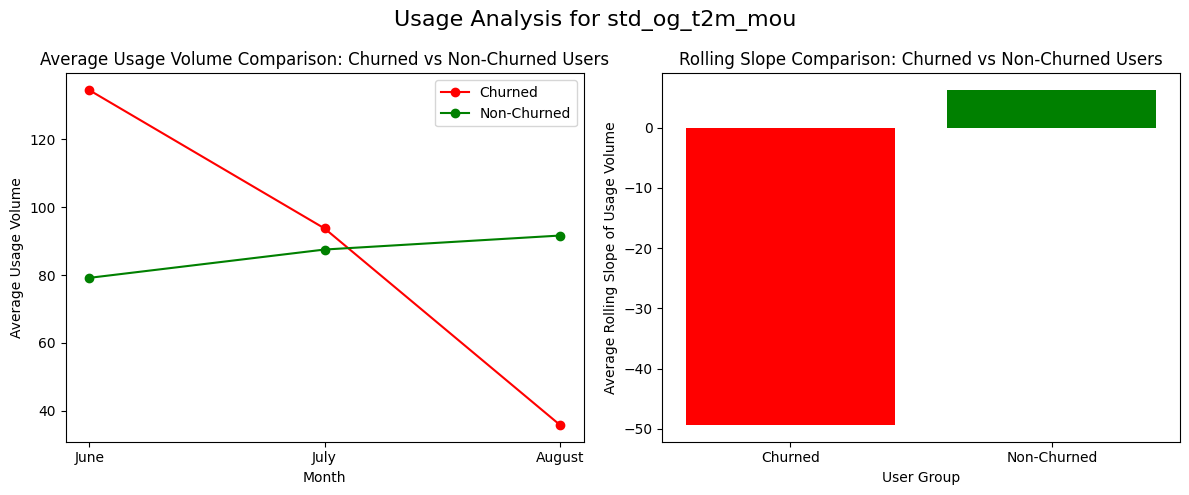

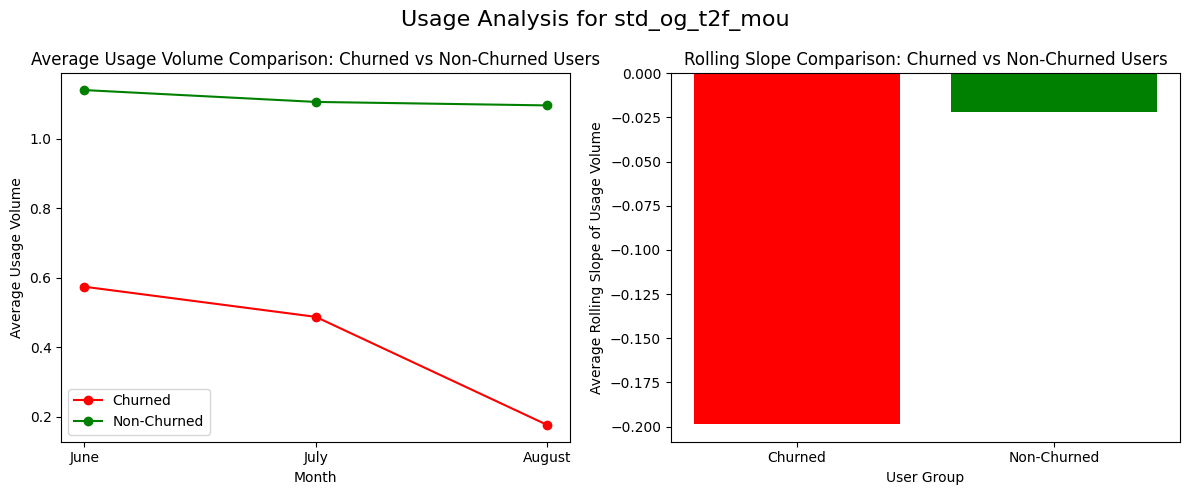

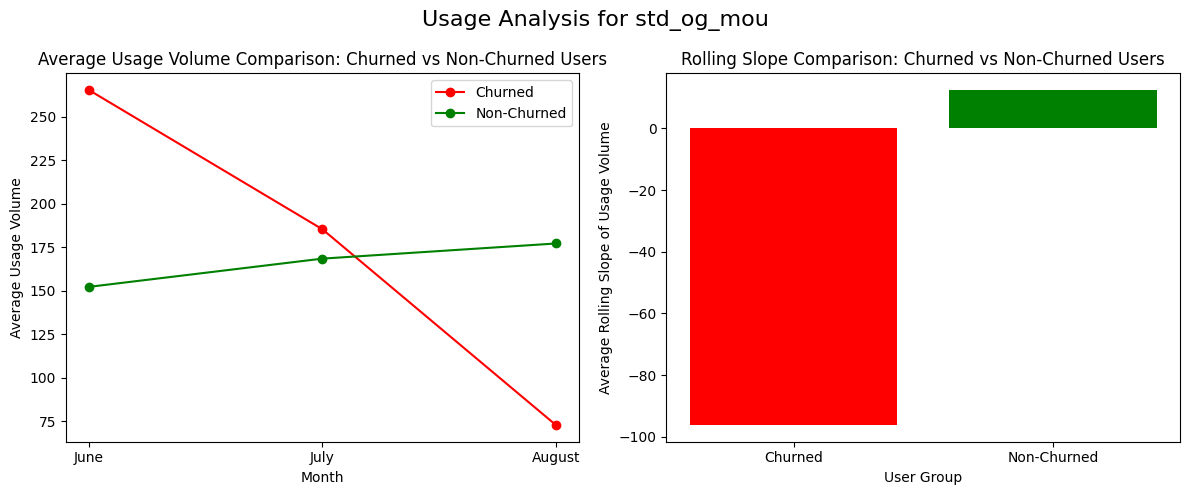

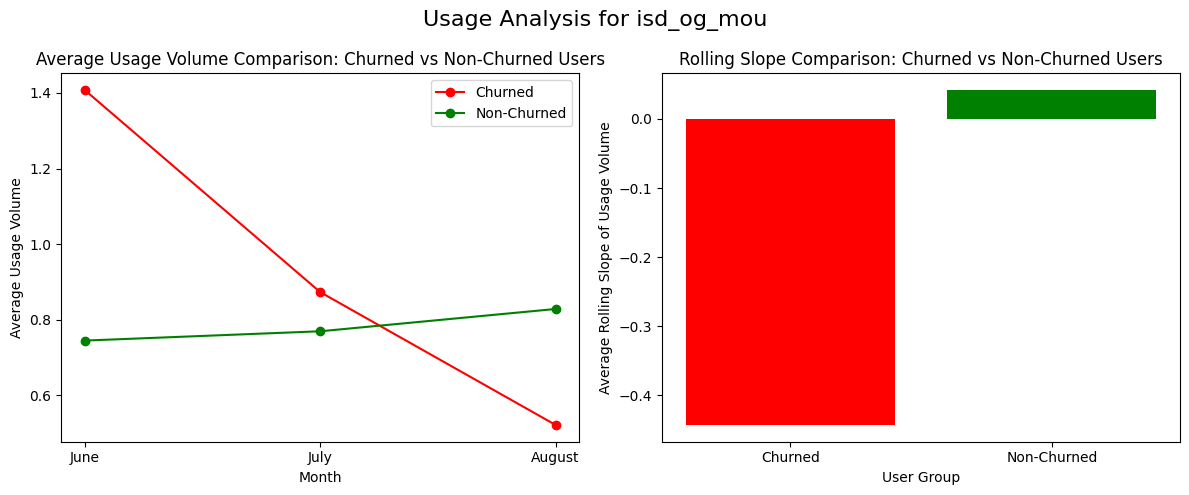

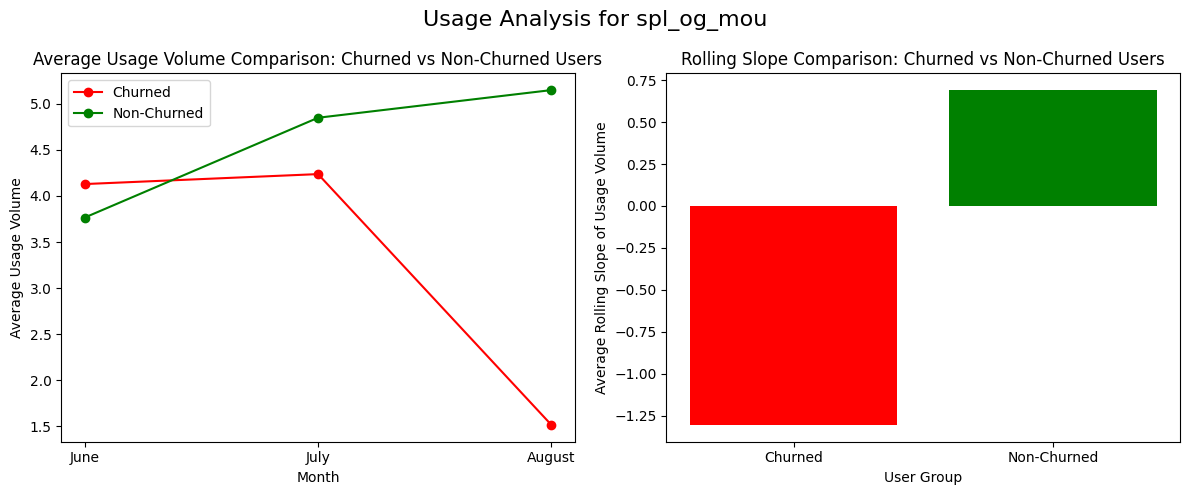

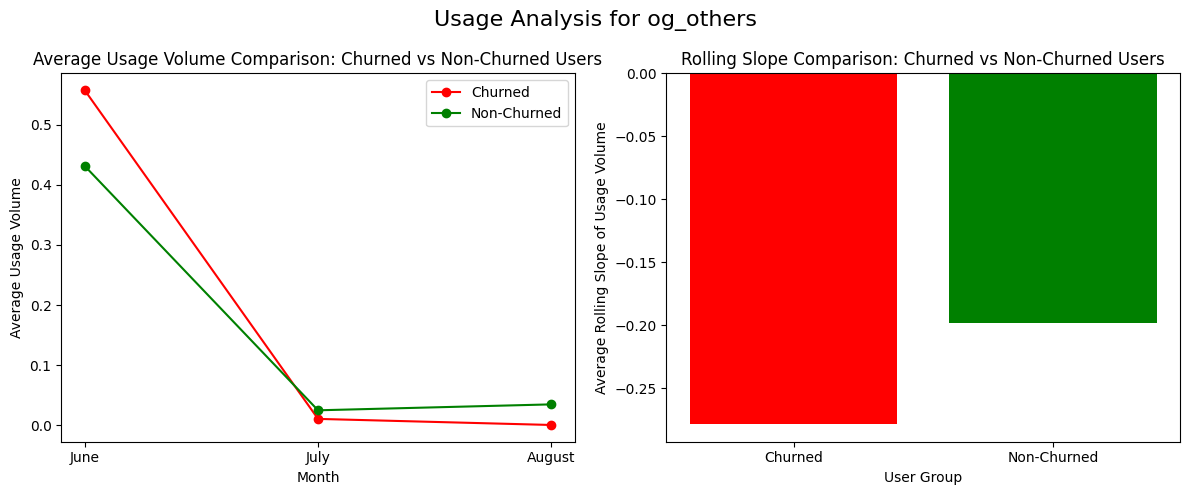

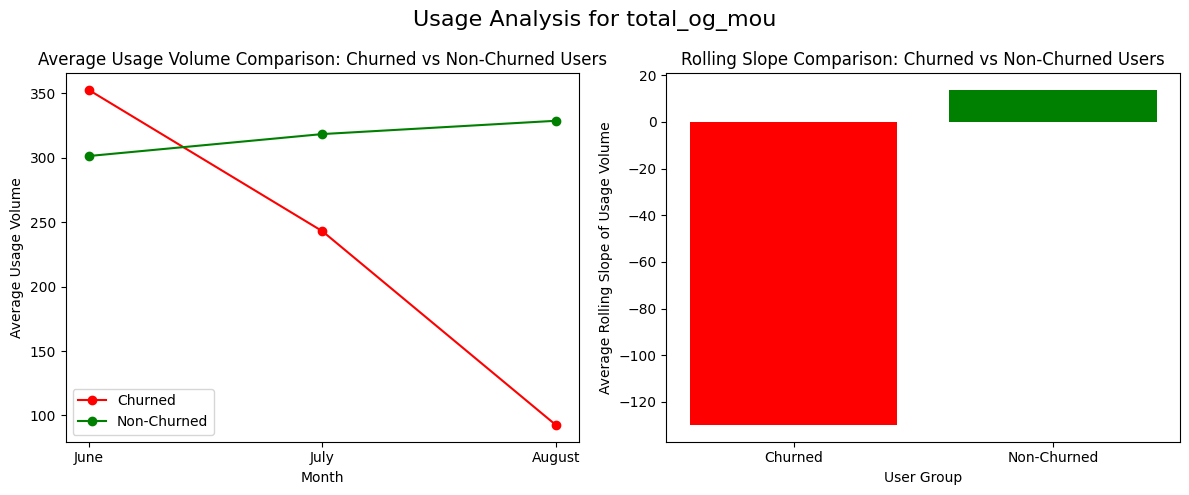

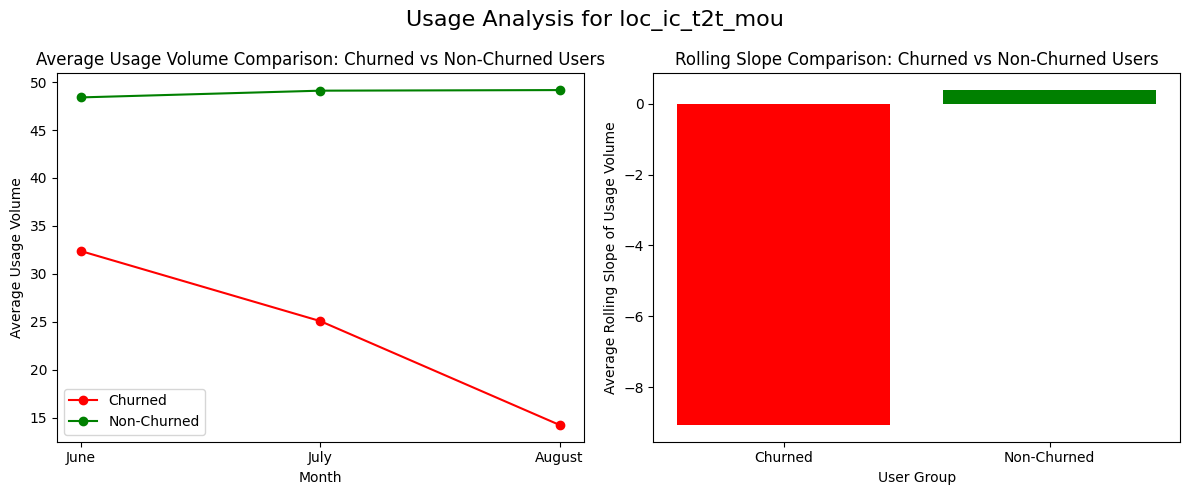

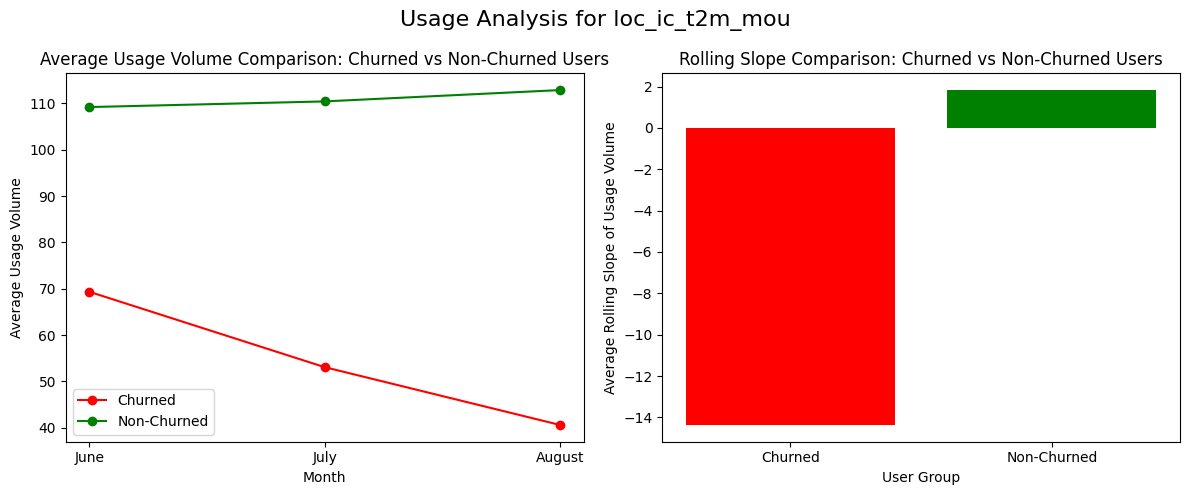

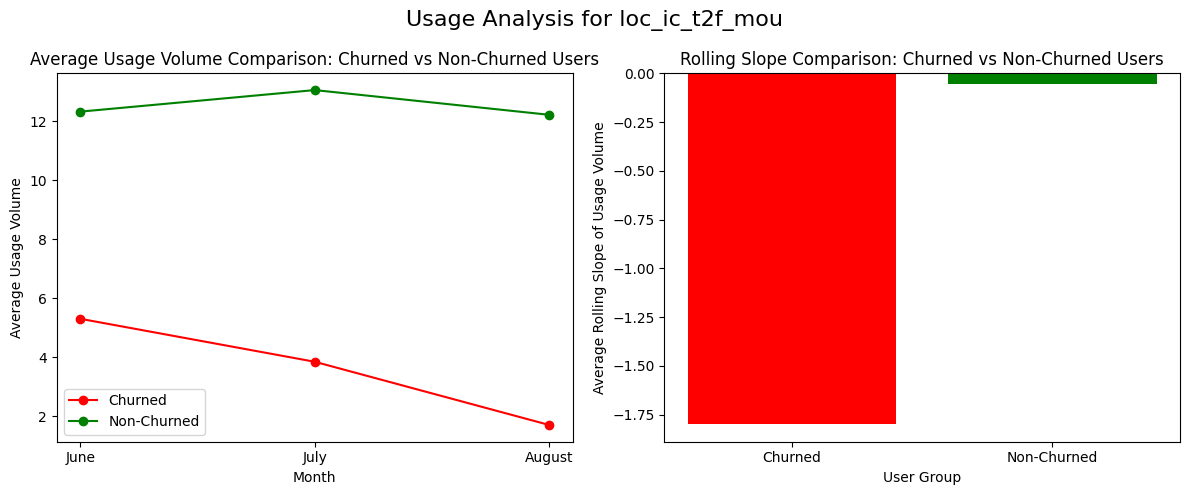

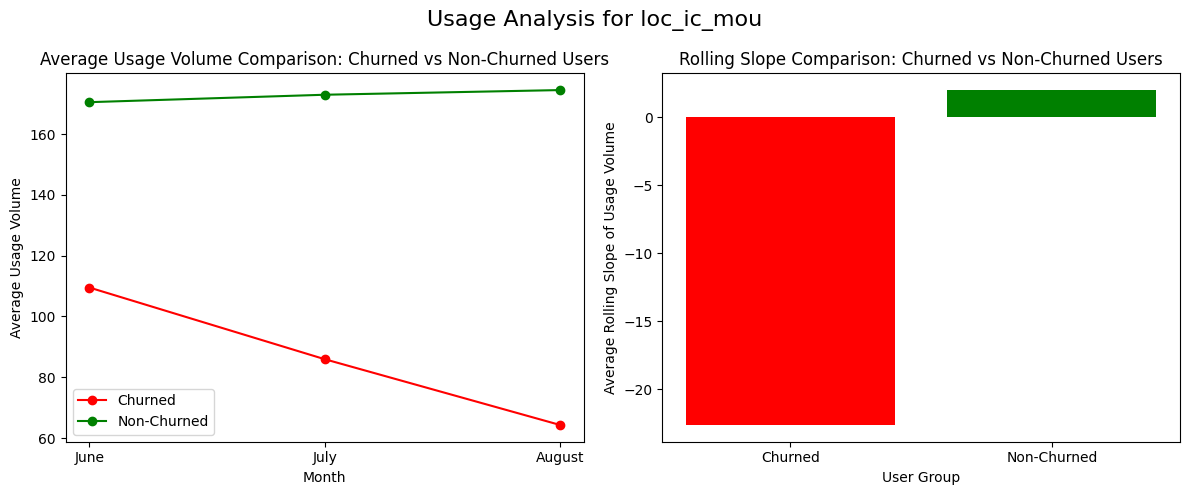

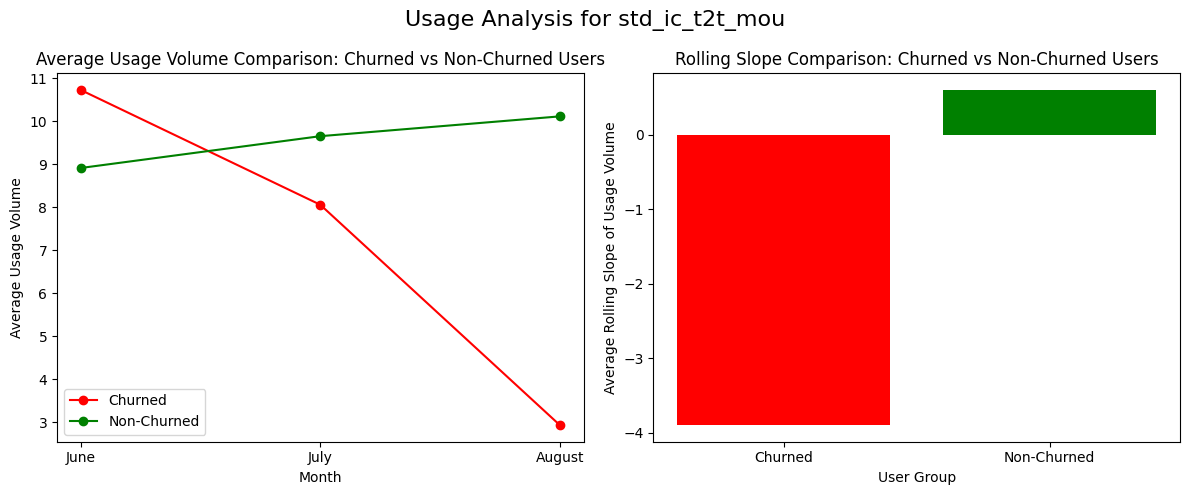

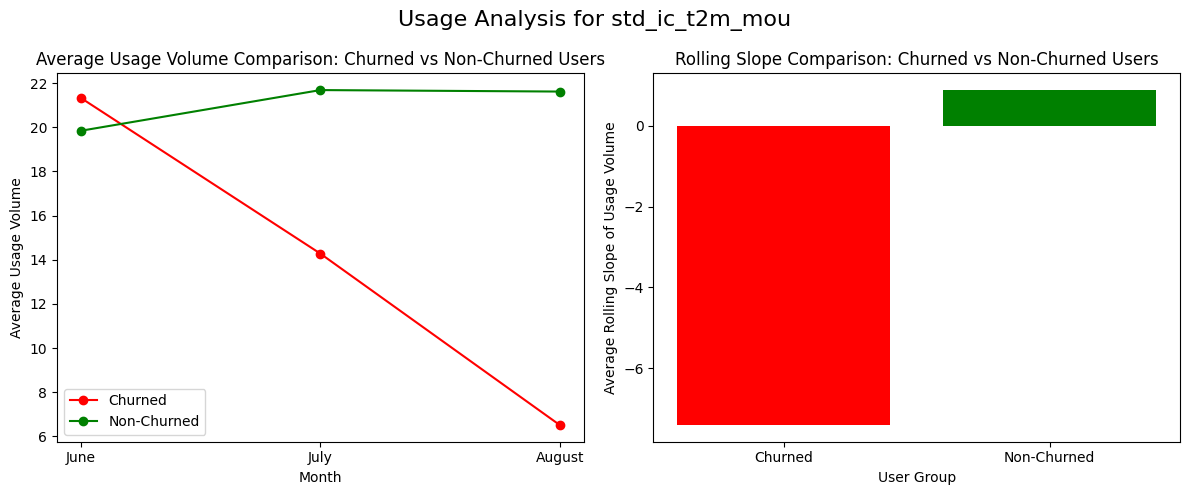

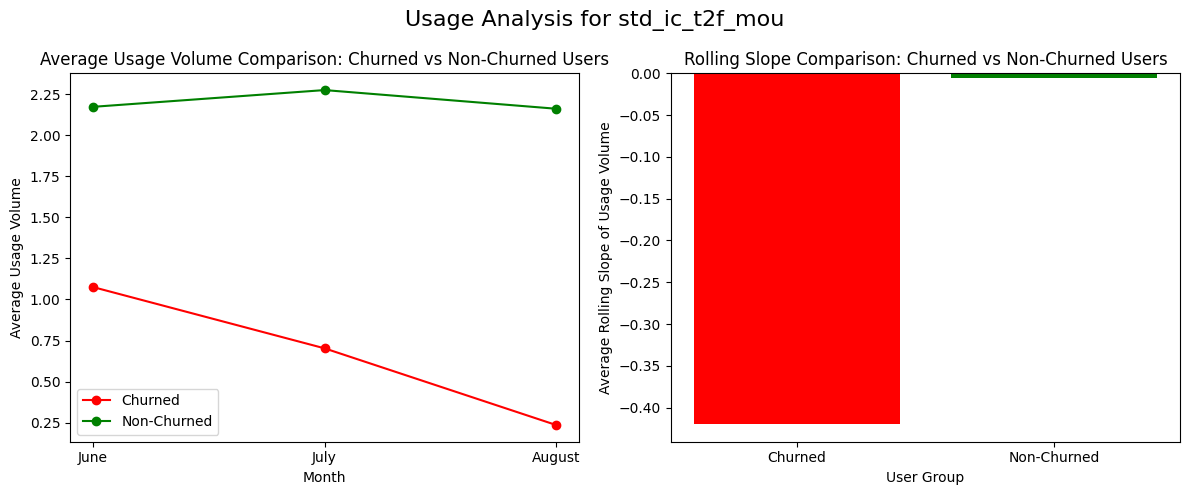

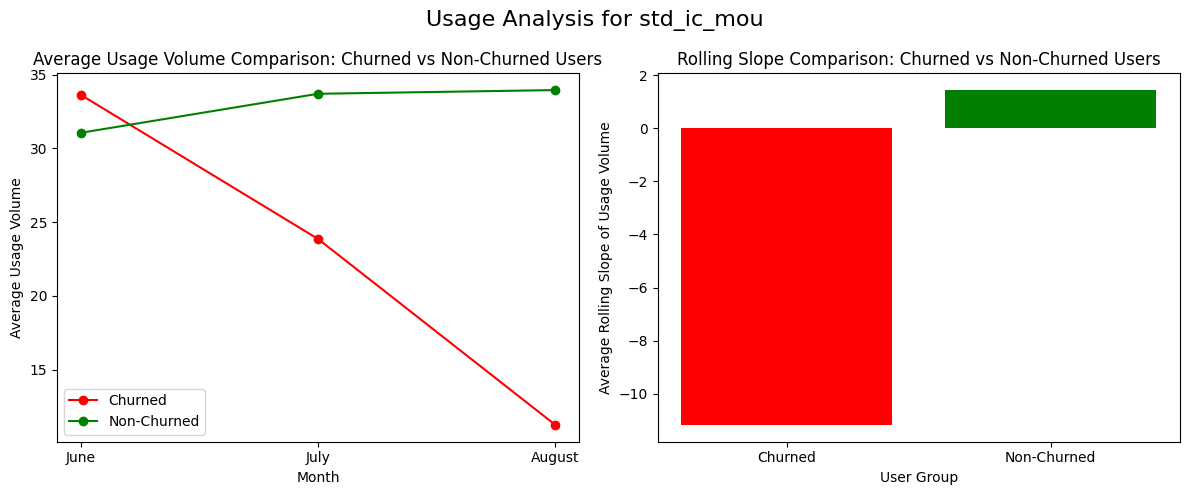

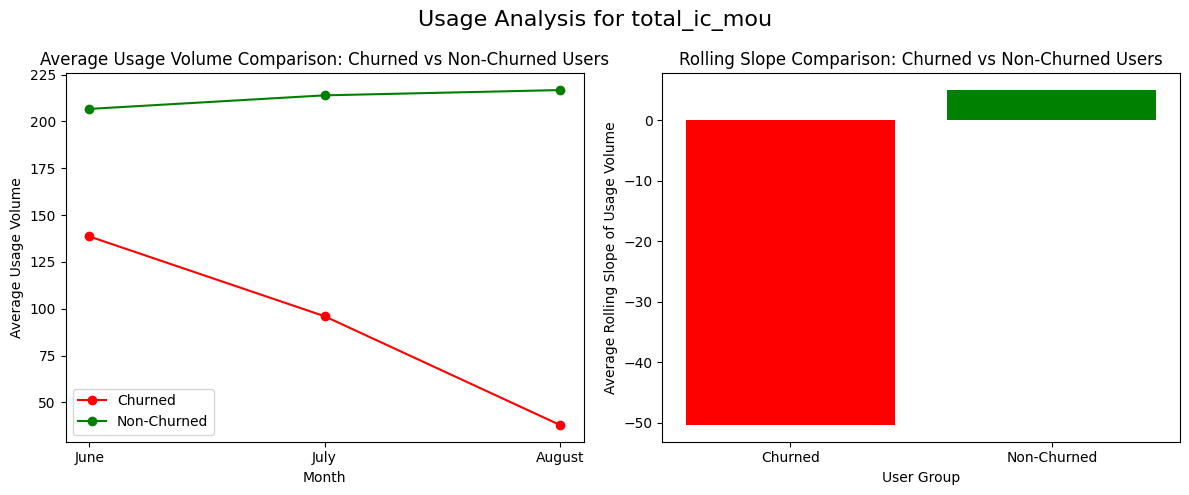

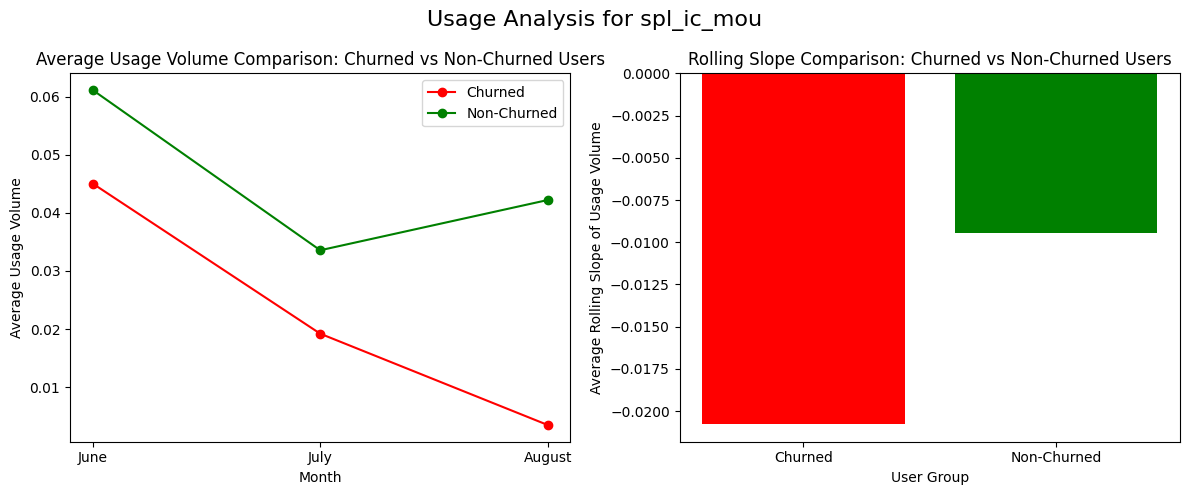

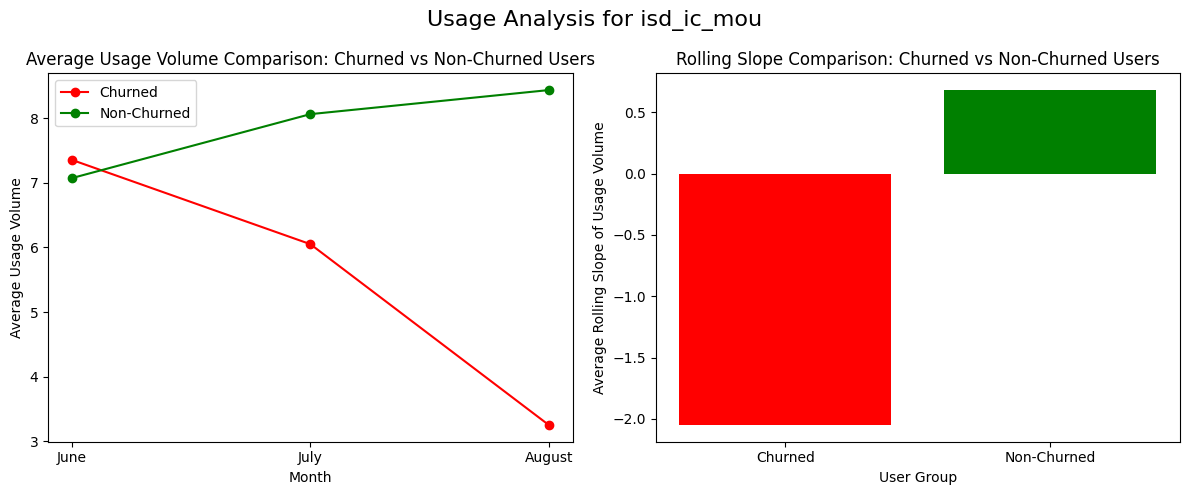

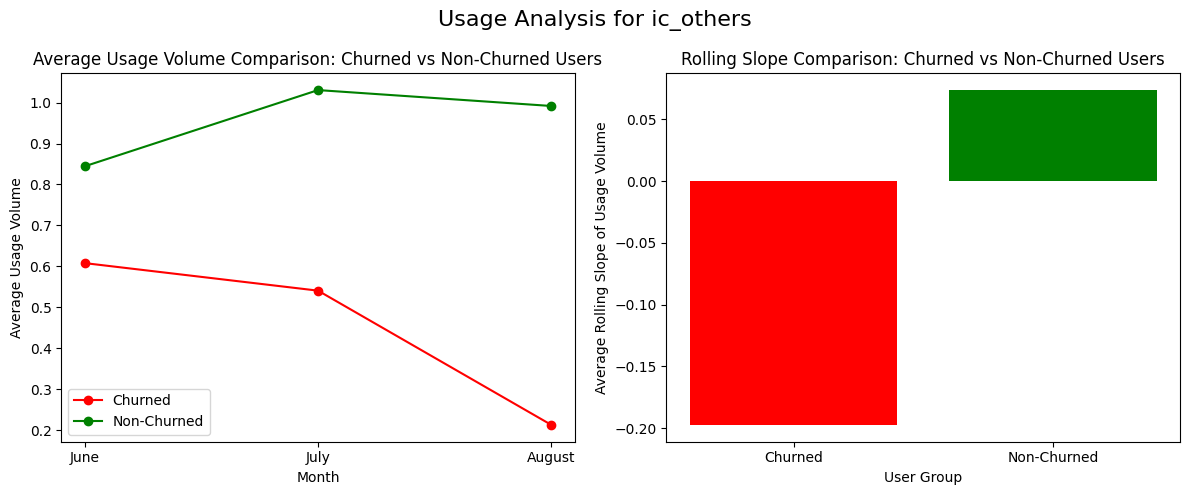

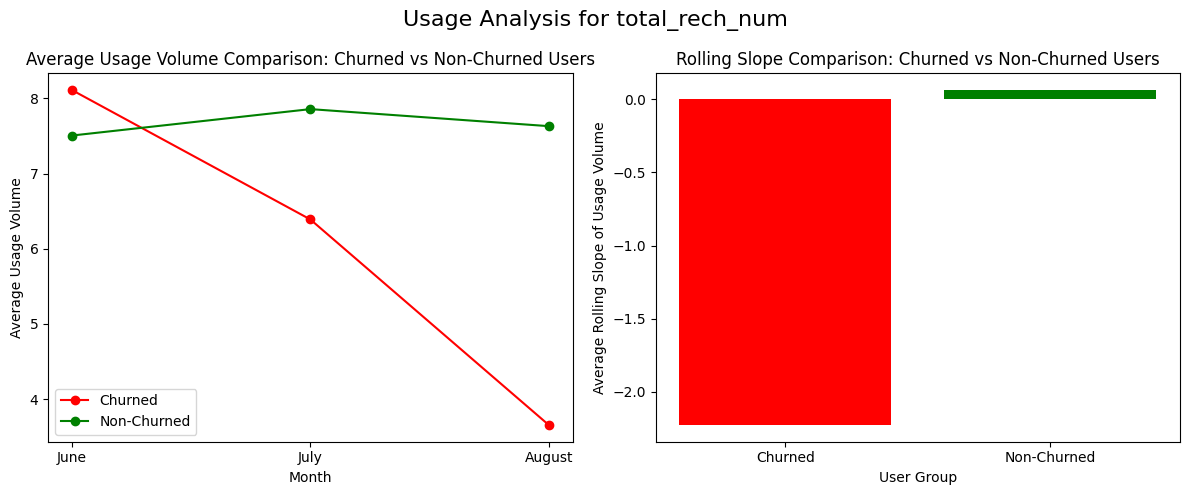

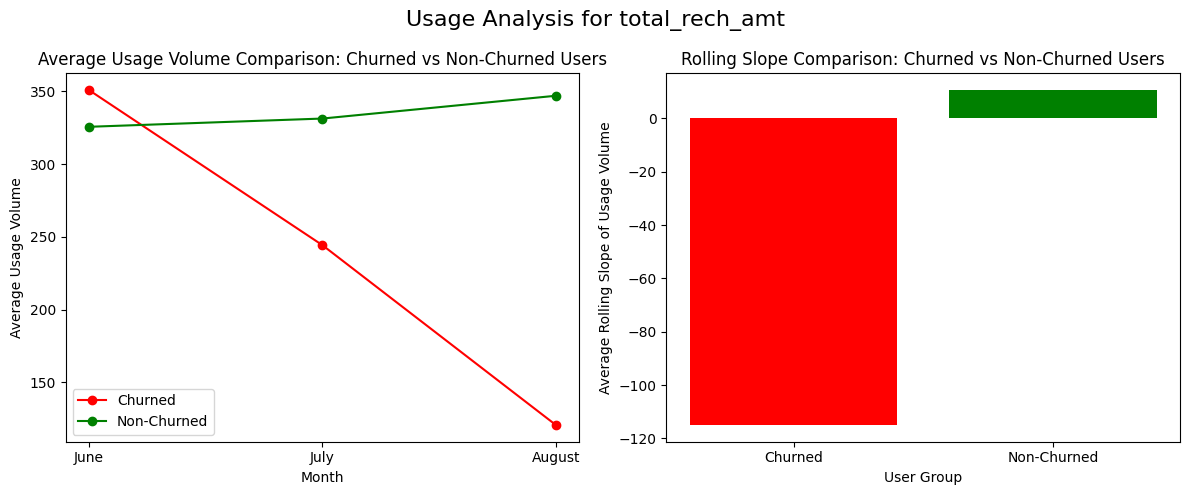

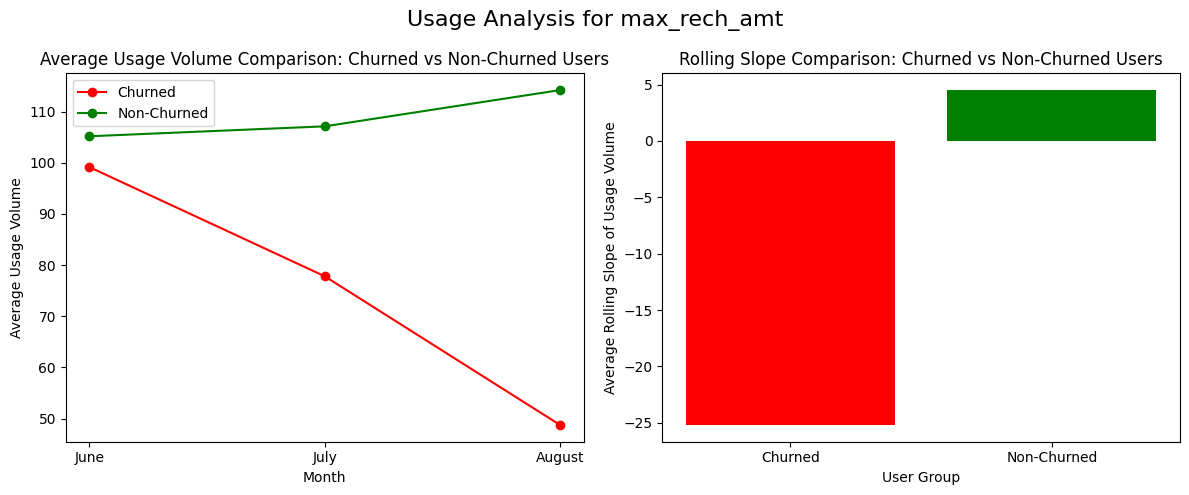

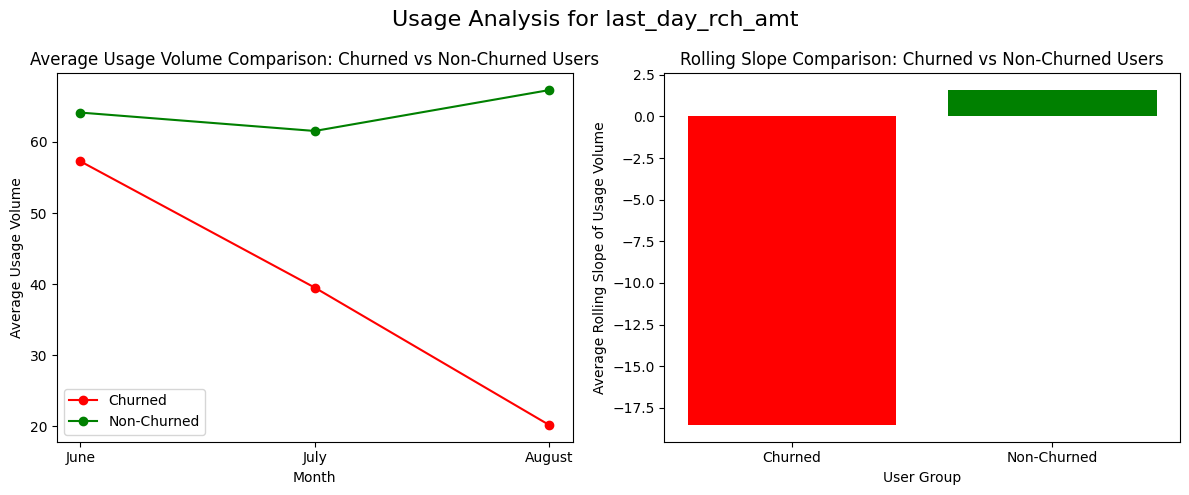

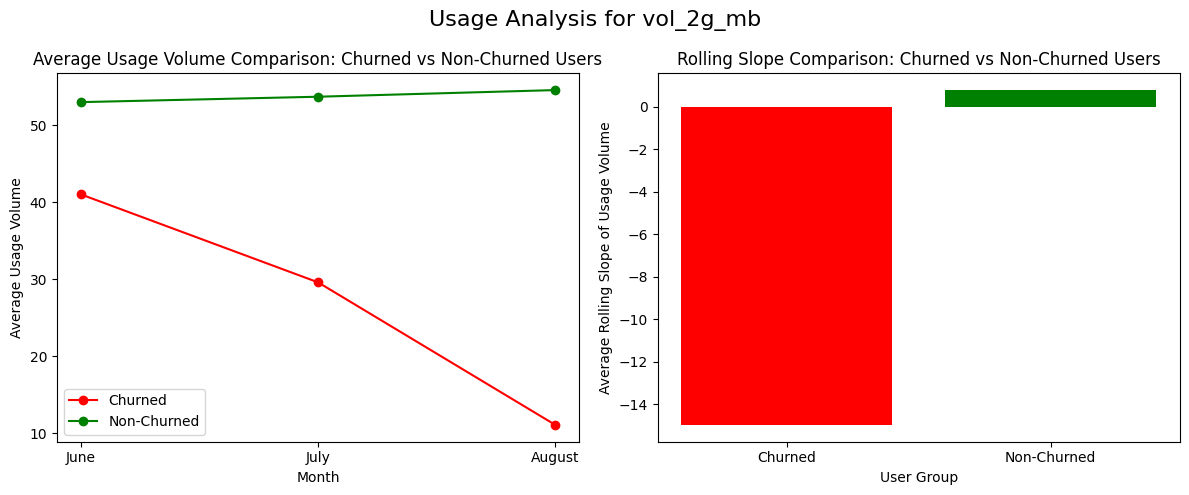

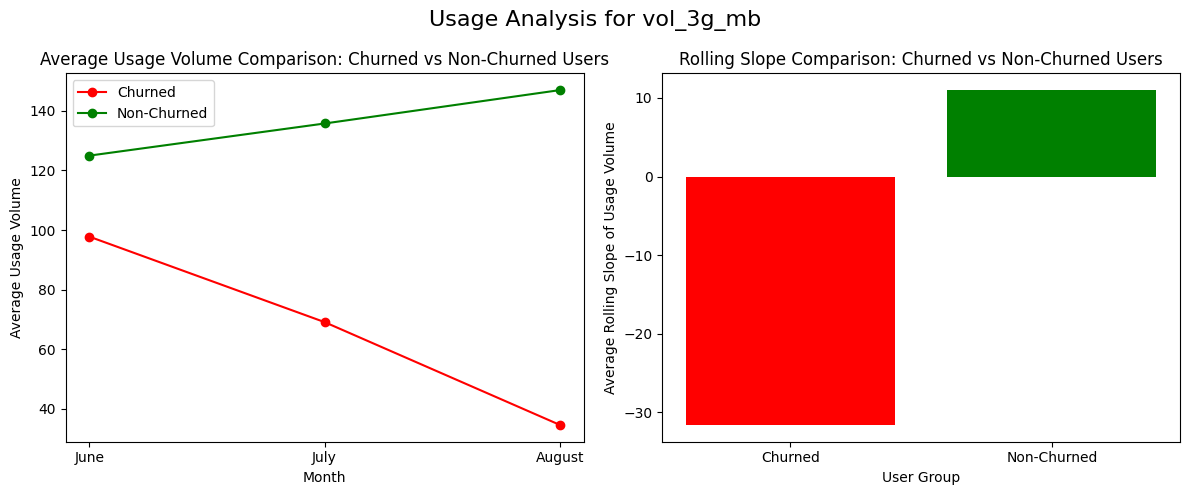

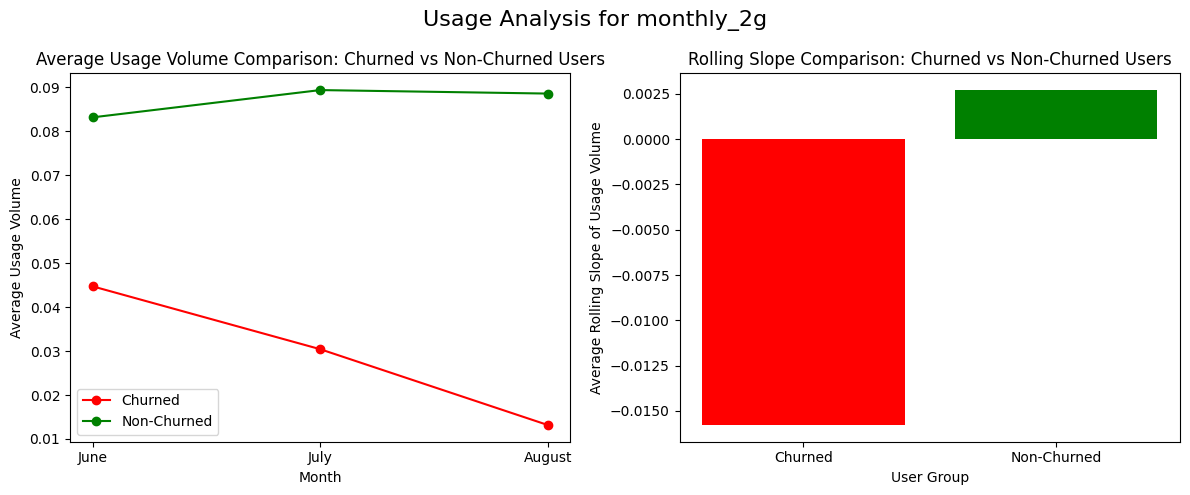

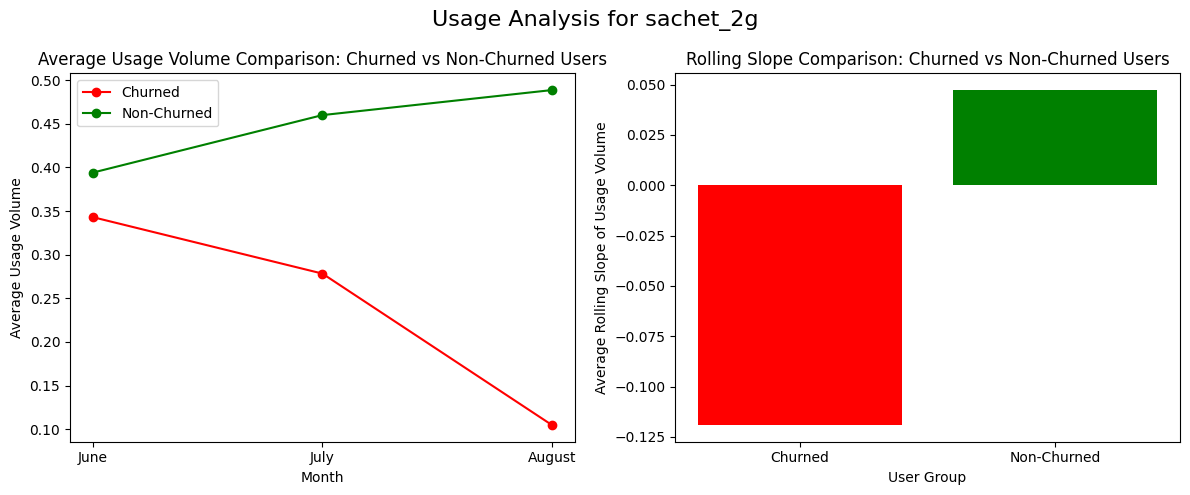

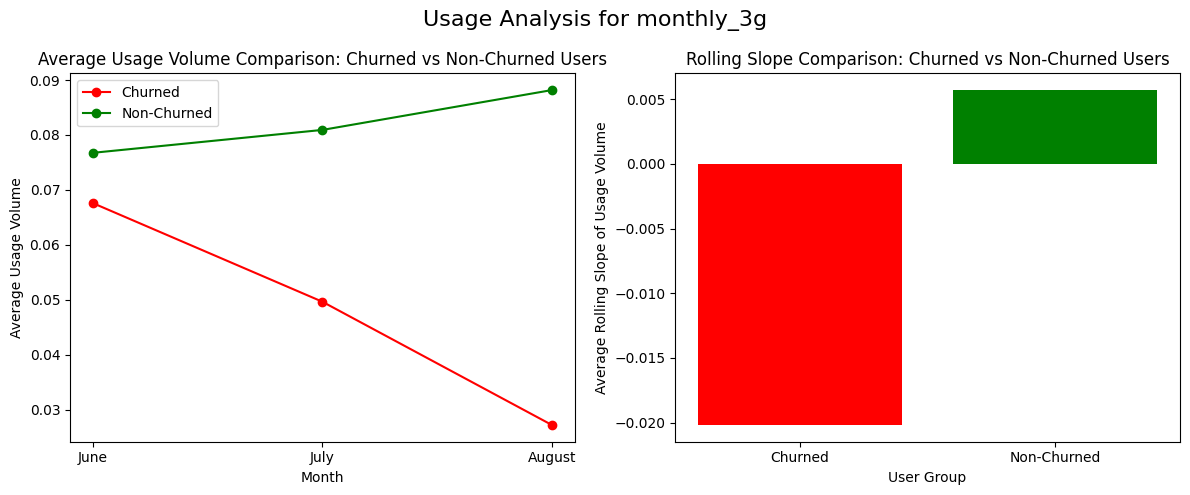

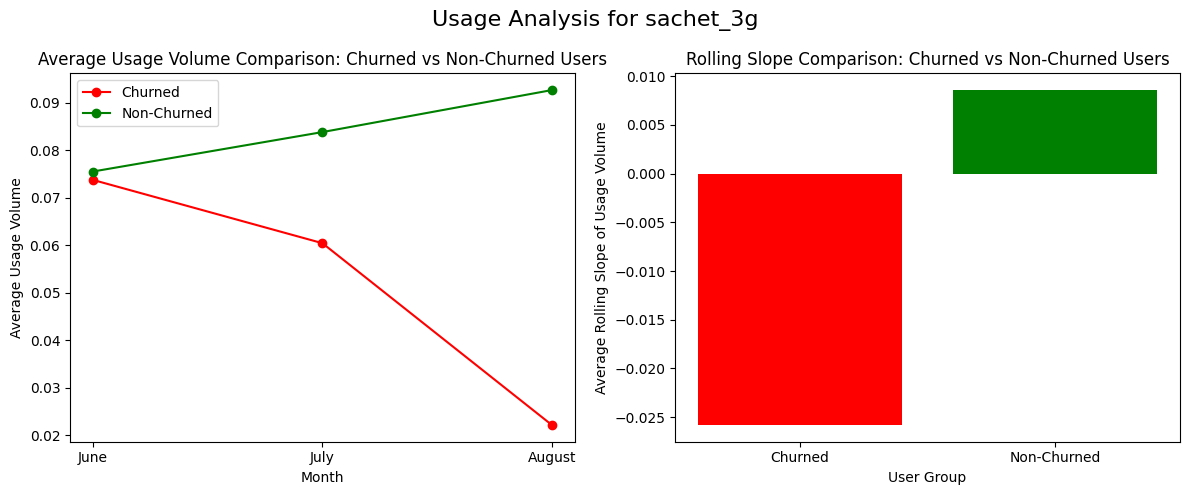

In [176]:
numeric_columns = data.select_dtypes(include=['number']).columns

for c in column_groups:
    if c[0] in numeric_columns:
        slope = change_in_usages(
            data=data,
            col_june=c[0],
            col_july=c[1],
            col_aug=c[2]
        )

        # plot_slope_comparison(
        #     data=data,
        #     slope=slope
        # )

        plot_combined_metrics(
            data=data,
            col_june=c[0],
            col_july=c[1],
            col_aug=c[2],        
            slope=slope
        )

In [177]:
data.columns

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'churn_probability', 'days_since_last_rech',
       'days_since_last_rech_data'],
      dtype='object', length=134)

In [182]:
pd.crosstab(data["churn_probability"], data["days_since_last_rech"])

days_since_last_rech,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0
churn_probability,,,,,,,,,,,,,,,,,,,,,
0,10169,8021,6453,6173,3872,5548,4897,4695,1198,1184,...,0,0,5,2,0,1,0,0,1,0
1,155,166,542,670,140,977,572,680,64,237,...,17,5,27,11,15,11,7,13,6,9


In [183]:
pd.crosstab(data["churn_probability"], data["days_since_last_rech_data"])

days_since_last_rech_data,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0
churn_probability,,,,,,,,,,,,,,,,,,,,,
0,1365,1292,1124,868,811,757,784,685,611,500,...,76,60,63,70,61,71,62,60,72,61
1,23,14,21,8,13,21,22,28,20,13,...,15,21,24,23,21,15,20,24,20,19
